# Проект на курсе Machine Learning Бакалавриат
### Тема проекта: Предсказание цен на акции российской биржи с учётом новостного потока
### Состав команды: Ступников Дмитрий, Клюшова Ульяна, Садоян Давид, Савин Владислав
### Задача проекта: научиться предсказывать на k <= 30 дней вперёд цены на акции МосБиржи, учитывая новостной поток

### Описание данных:


Датасет 1 (candle) - Ценовые данные (OHLCV): open, high, low, close, volume с 19.06.2020 до 08.09.2025 по 19 тикерам с МосБиржи. Это соответственно начальная, максимальная, минимальная, конечная цена и объём за каждый из торгуемых дней


Датасет 2 (news) - Новостные данные с портала finam.ru - крупнейшего российского брокера (у них мы и позаимствовали данный датасет): дата публикации, заголовок, текст


In [ ]:

!pip install transformers torch tqdm bitsandbytes

In [ ]:
import pandas as pd
import gdown
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
import numpy as np

## EDA Датасета candle
Изначально датасет был разделён на до 2025 и после 2025, как на train и test, мы его соединяем и дальше уже будем работать

In [ ]:
url_candles = 'https://drive.google.com/file/d/12n1JmpNTDgNpRVuv9oF1MwsyNZQELTmi/view?usp=share_link'
url_candles_2 = 'https://drive.google.com/file/d/1BN5NCtZ3k6NUuvX2M1xAiZZ91vDGc2BH/view?usp=share_link'

file_id_train = url_candles.split('/')[-2]
local_file_path_train = 'df_candles.csv'
gdown.download(id=file_id_train, output=local_file_path_train, quiet=False)

file_id_test = url_candles_2.split('/')[-2]
local_file_path_test = 'df_candles_2.csv'
gdown.download(id=file_id_test, output=local_file_path_test, quiet=False)

df_candels = pd.read_csv(local_file_path_train)
df_candels_2 = pd.read_csv(local_file_path_test)

print(f"размерность датасета до 2025 года: {df_candels.shape}")
print(f"размерность датасета  2025 года: {df_candels_2.shape}")

Downloading...
From: https://drive.google.com/uc?id=12n1JmpNTDgNpRVuv9oF1MwsyNZQELTmi
To: /content/df_candles.csv
100%|██████████| 1.25M/1.25M [00:00<00:00, 205MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BN5NCtZ3k6NUuvX2M1xAiZZ91vDGc2BH
To: /content/df_candles_2.csv
100%|██████████| 89.0k/89.0k [00:00<00:00, 73.5MB/s]

размерность датасета до 2025 года: (24197, 7)
размерность датасета  2025 года: (1745, 7)


In [ ]:
df = pd.concat([df_candels, df_candels_2], ignore_index=True)
print("Общий датасет:", df.shape)


Общий датасет: (25942, 7)


In [ ]:
display(df.head())
df.info()
df.describe()


open  close   high    low    volume       begin ticker
0  81.50  81.70  83.20  81.16  29755530  2020-06-19   AFLT
1  81.72  82.10  83.98  80.26  18502950  2020-06-22   AFLT
2  82.04  81.20  82.48  80.40  16848930  2020-06-23   AFLT
3  79.78  80.58  80.80  78.22  21559860  2020-06-25   AFLT
4  80.50  79.38  81.44  78.76  14677280  2020-06-26   AFLT

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25942 entries, 0 to 25941
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    25942 non-null  float64
 1   close   25942 non-null  float64
 2   high    25942 non-null  float64
 3   low     25942 non-null  float64
 4   volume  25942 non-null  int64  
 5   begin   25942 non-null  object 
 6   ticker  25942 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.4+ MB


open         close          high           low        volume
count  25942.000000  25942.000000  25942.000000  25942.000000  2.594200e+04
mean    1400.465847   1399.723822   1418.708326   1379.193781  3.154513e+09
std     2093.777230   2092.542764   2119.684280   2063.558303  2.280749e+10
min       21.900000     22.440000     23.280000     21.440000  1.246000e+03
25%      113.800000    113.800000    115.378750    112.142500  5.113432e+05
50%      310.975000    310.970000    313.970000    308.695000  2.900915e+06
75%     1481.150000   1481.425000   1503.537500   1457.875000  1.767637e+07
max     9000.000000   8908.000000  10097.000000   8500.000000  7.032681e+11

In [ ]:
df["begin"] = pd.to_datetime(df["begin"])

In [ ]:
missing = df.isnull().sum()
print(missing)

open      0
close     0
high      0
low       0
volume    0
begin     0
ticker    0
dtype: int64


кайф)

In [ ]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
25937    False
25938    False
25939    False
25940    False
25941    False
Length: 25942, dtype: bool

In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates()


321


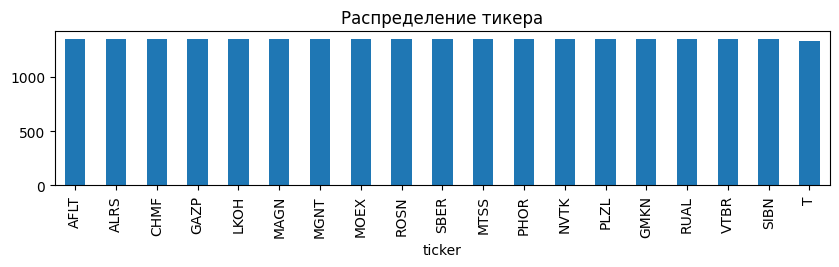

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10,2))
    df[col].value_counts().plot.bar()
    plt.title(f"Распределение тикера")
    plt.show()


сделаем анализ временного ряда для каждого тикера

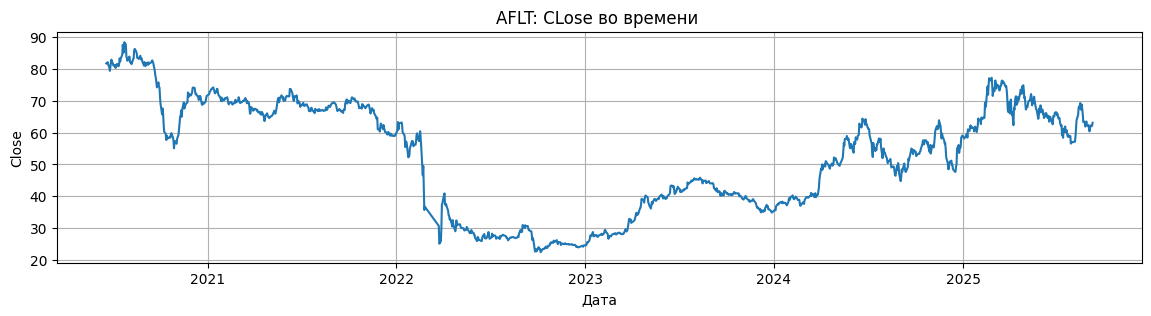

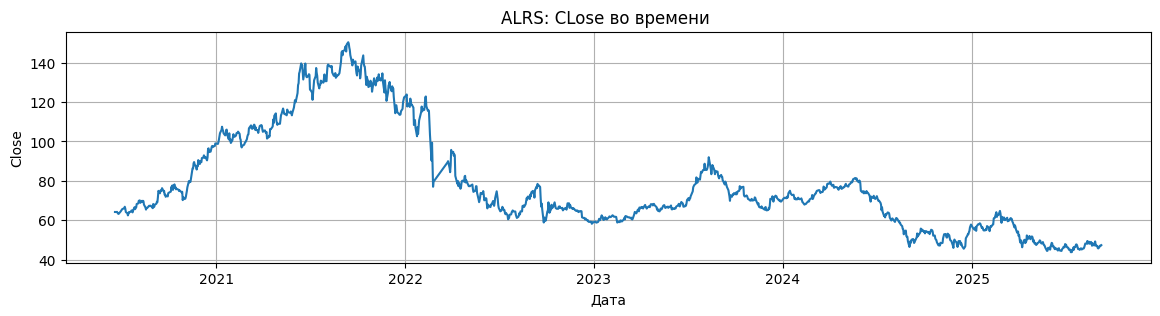

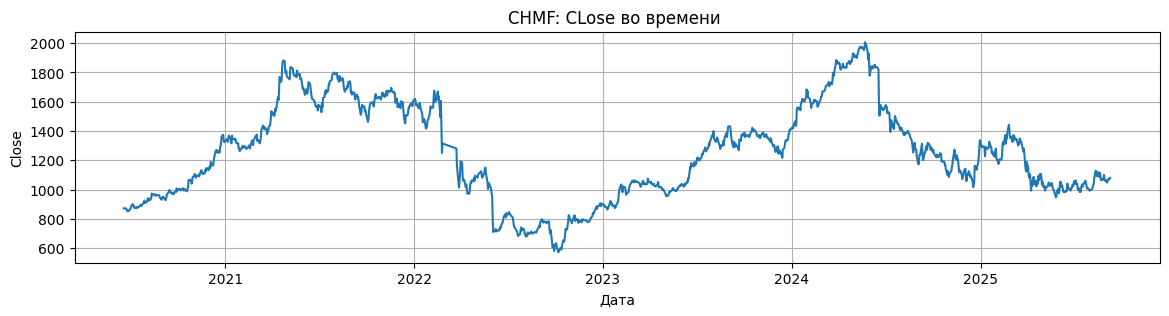

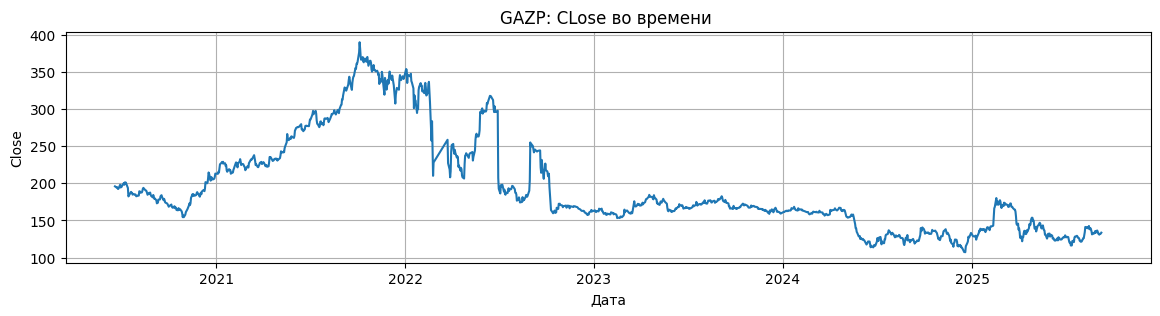

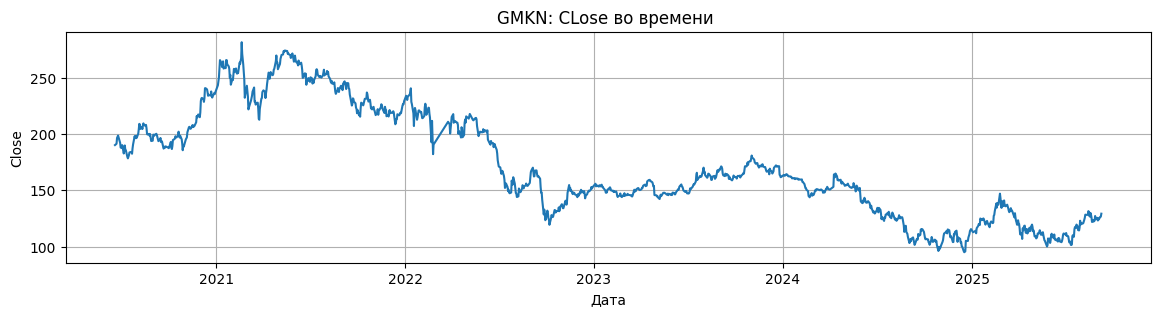

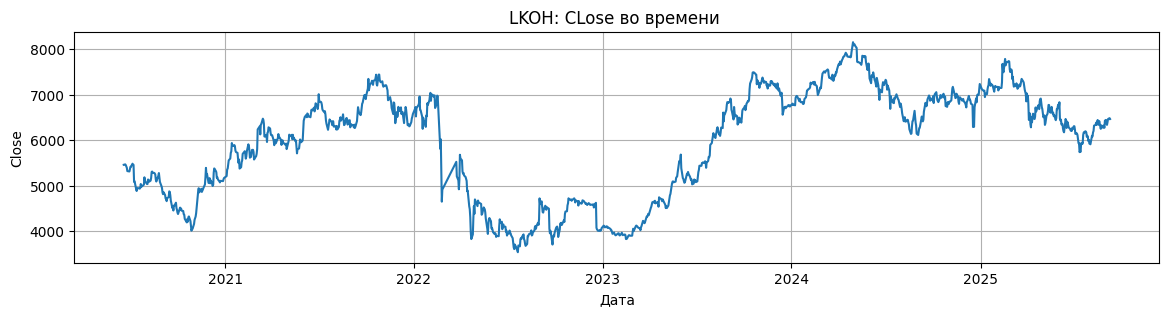

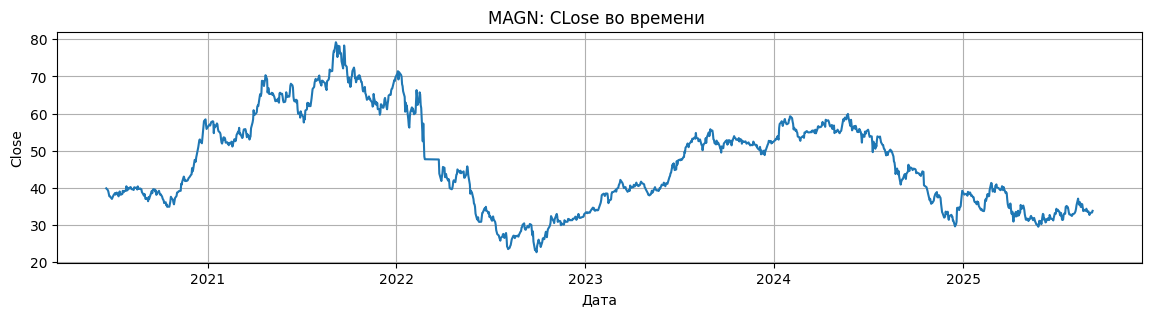

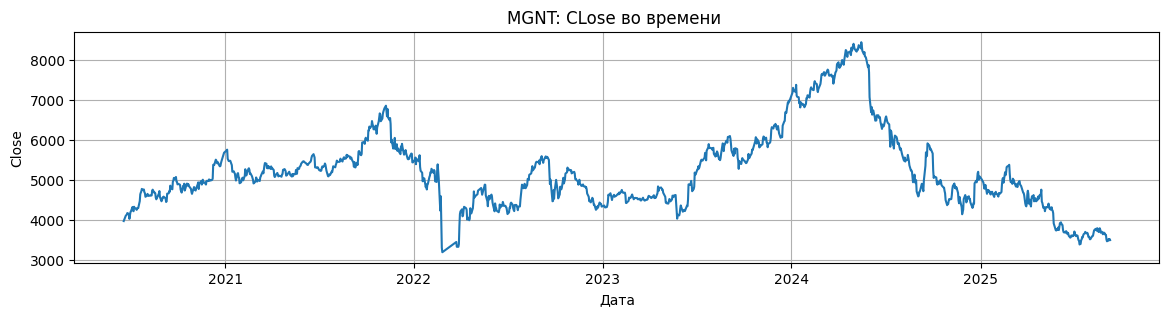

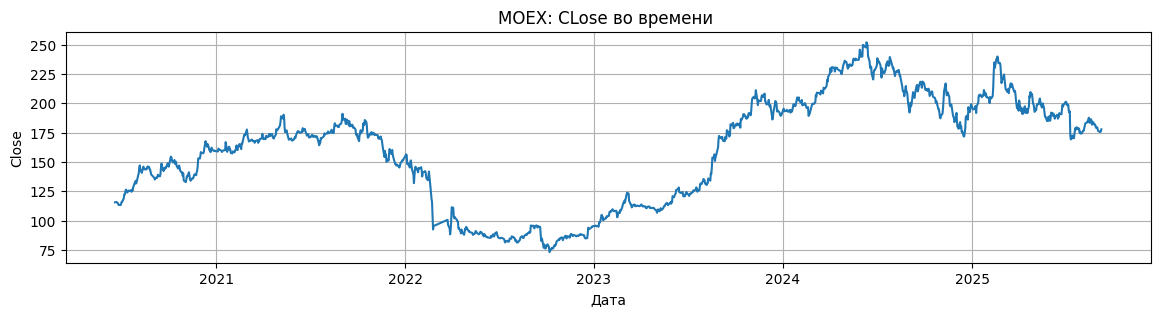

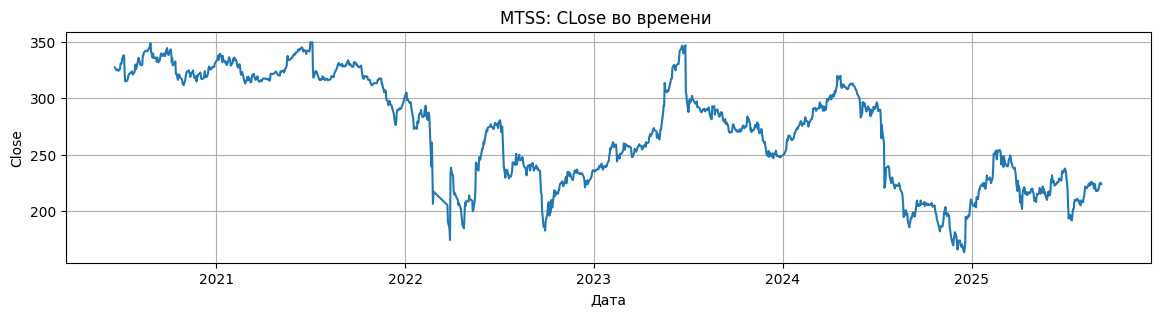

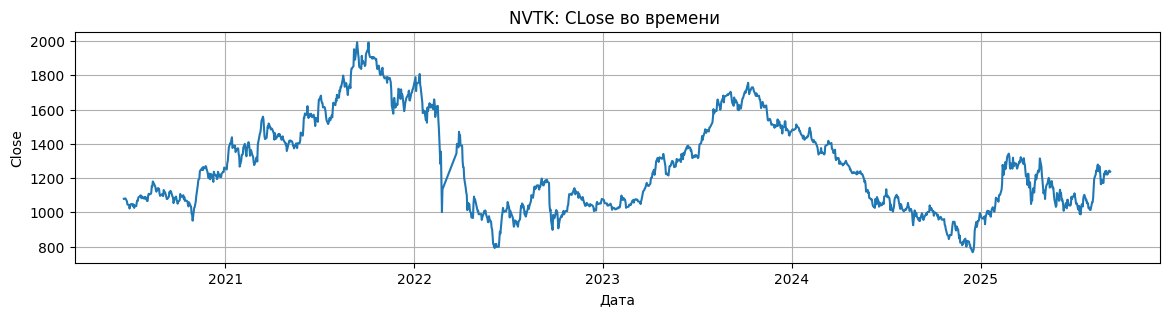

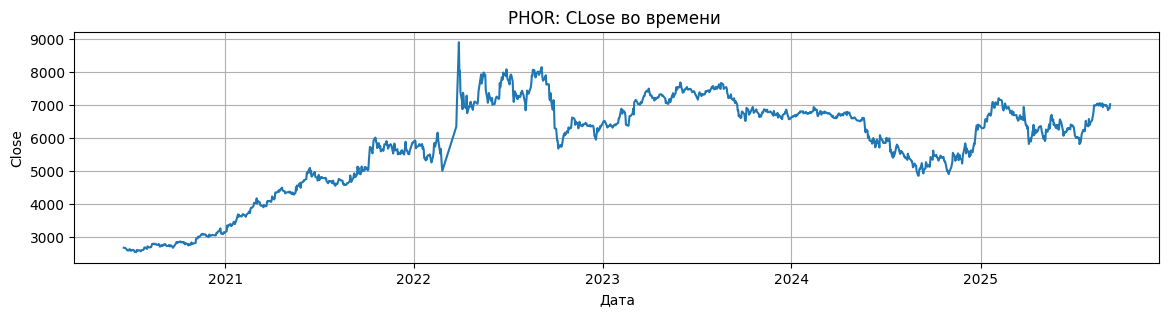

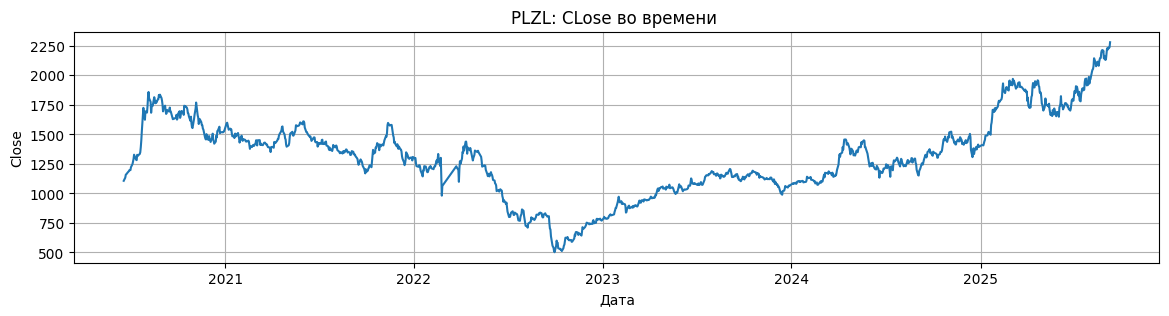

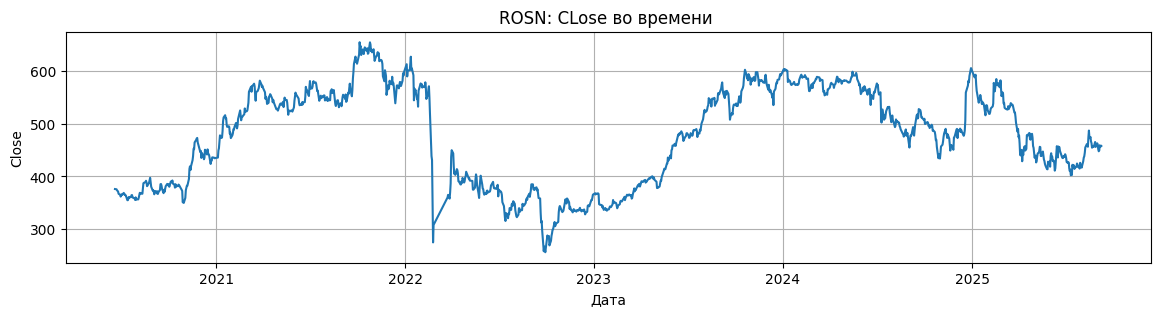

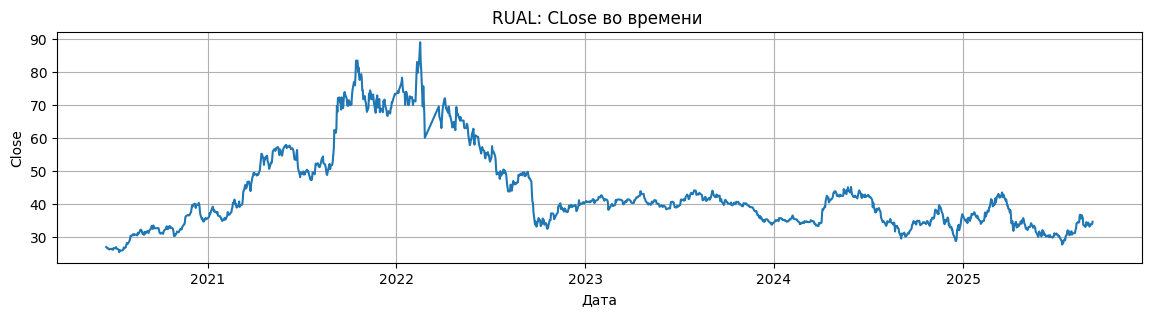

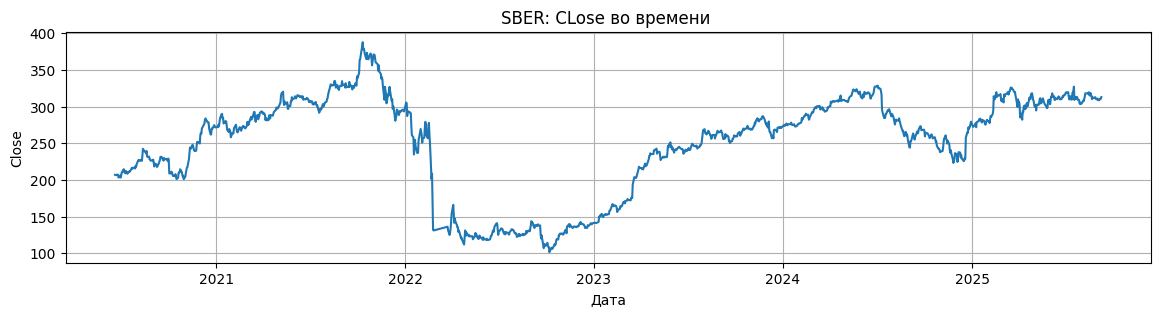

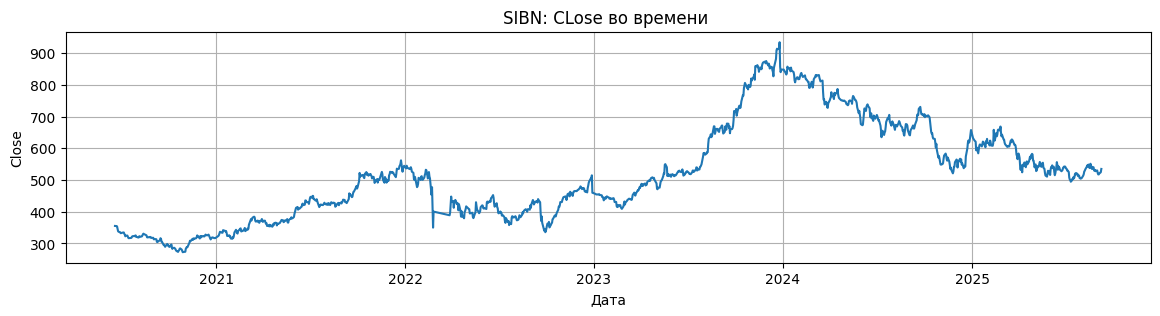

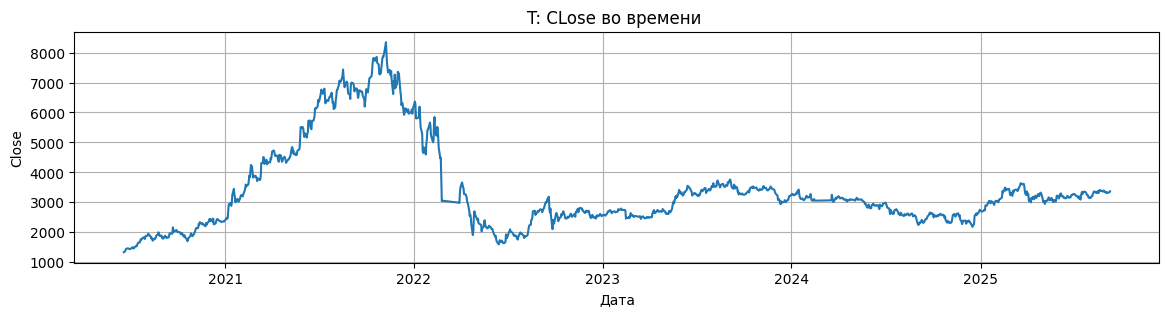

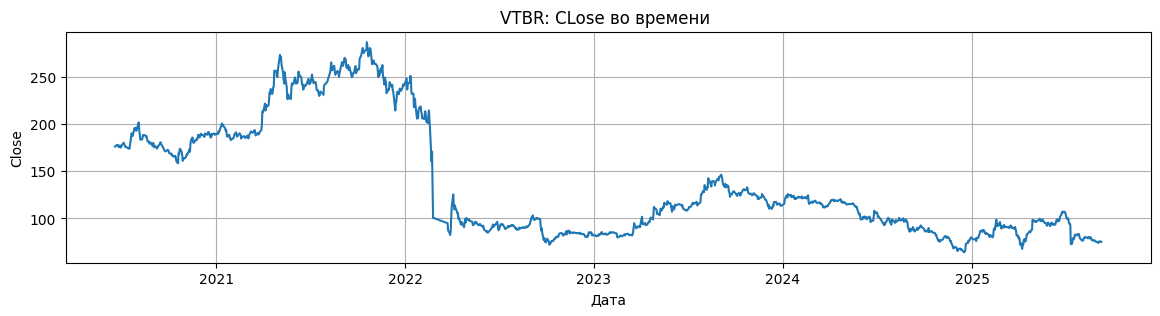

In [ ]:
for ticker in df['ticker'].unique():
    plt.figure(figsize=(14,3))
    df_tic = df[df['ticker'] == ticker].sort_values('begin')
    plt.plot(df_tic['begin'], df_tic['close'])
    plt.title(f'{ticker}: CLose во времени ')
    plt.xlabel("Дата")
    plt.ylabel("Close")
    plt.grid()
    plt.show()


имеются аномалии а также разрывы (мы сами их каким-то образом сделали, хз как, я тут часть поудалял, теперь разрывов нет)

посмотрим на суточные доходы

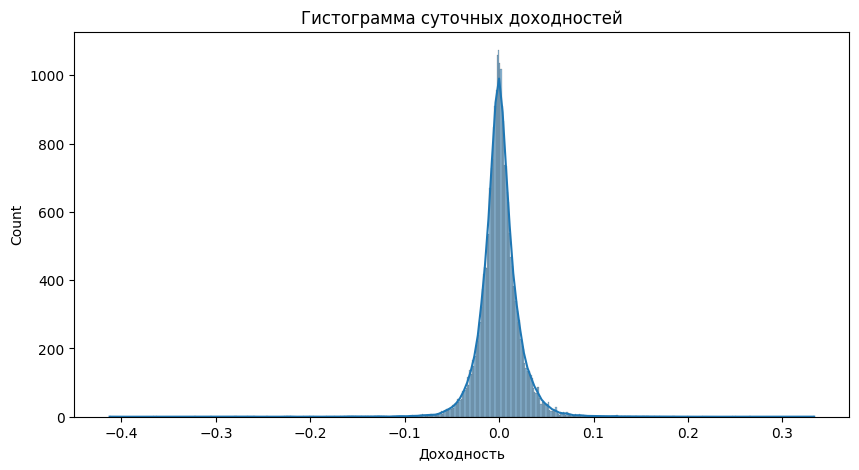

In [ ]:
df = df.sort_values(['ticker', 'begin'])
df['return'] = df.groupby('ticker')['close'].pct_change()

plt.figure(figsize=(10,5))
sns.histplot(df['return'].dropna(), kde=True)
plt.title('Гистограмма суточных доходностей')
plt.xlabel('Доходность')
plt.show()


вроде как нормальное распределение) уже хорошо

In [ ]:
df['return'].describe()

count    25602.000000
mean         0.000336
std          0.022487
min         -0.412538
25%         -0.009538
50%          0.000000
75%          0.009914
max          0.333715
Name: return, dtype: float64

хотя тут есть хвост побольше в отрицательную сторону

У нас еще доходность от обьема

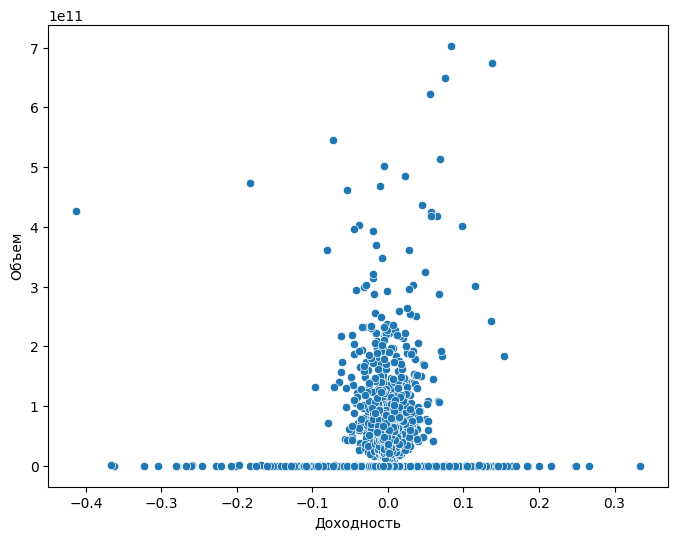

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='return', y='volume', data=df)
plt.xlabel('Доходность')
plt.ylabel('Объем')
plt.show()


ну да в целом хвост возник из за маленьких обьемов. Так что некритично

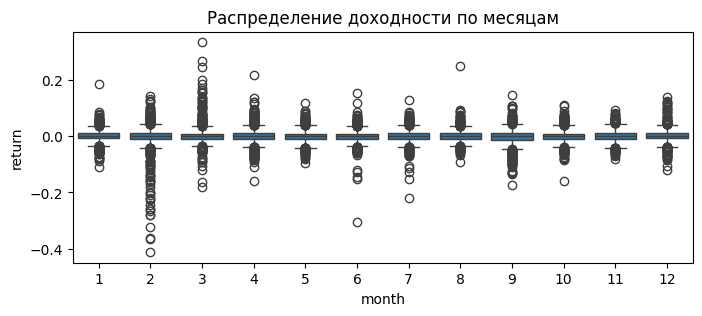

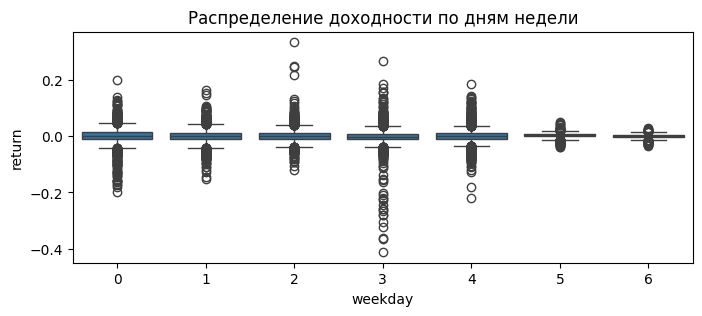

In [ ]:
df['month'] = df['begin'].dt.month
df['weekday'] = df['begin'].dt.weekday
plt.figure(figsize=(8,3))
sns.boxplot(x='month', y='return', data=df)
plt.title('Распределение доходности по месяцам')
plt.show()

plt.figure(figsize=(8,3))
sns.boxplot(x='weekday', y='return', data=df)
plt.title('Распределение доходности по дням недели')
plt.show()


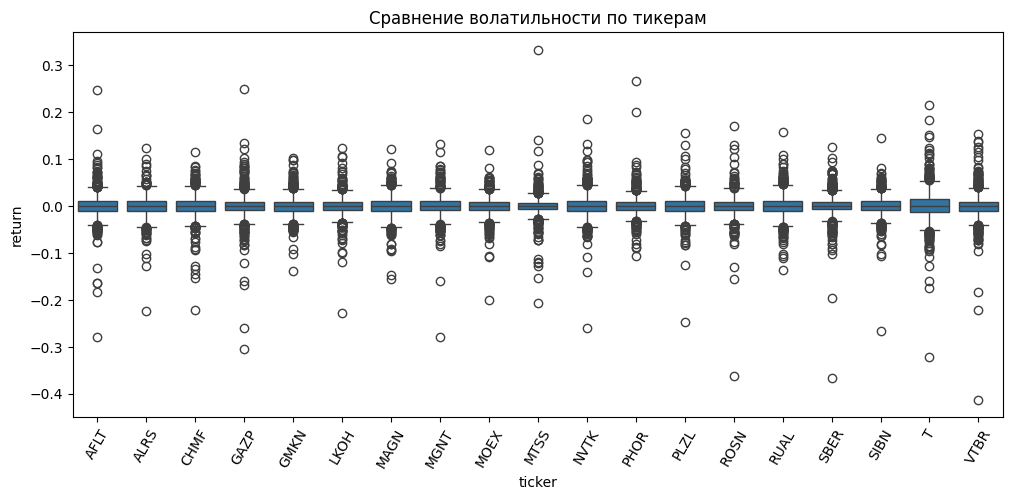

In [ ]:
plt.figure(figsize=(12,5))
sns.boxplot(x='ticker', y='return', data=df)
plt.title('Сравнение волатильности по тикерам')
plt.xticks(rotation=60)
plt.show()


неудивительно что T один из самых волотильных

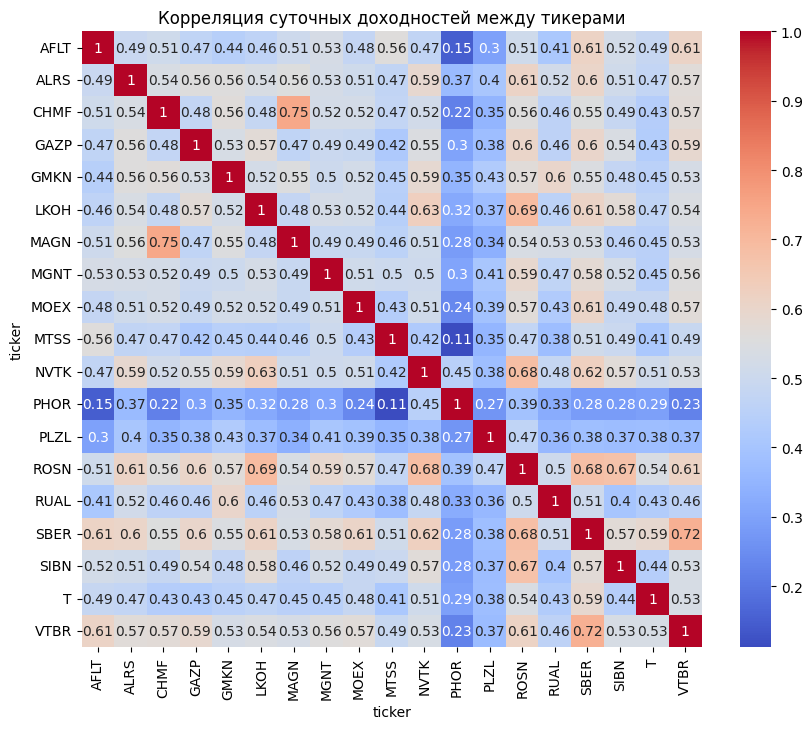

In [ ]:
df_for_pivot = df.groupby(['begin', 'ticker'])['return'].mean().reset_index()
returns = df_for_pivot.pivot(index='begin', columns='ticker', values='return')
plt.figure(figsize=(10,8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция суточных доходностей между тикерами')
plt.show()

как видим у нас большинство тикеров между собой очень хорошо коррелируют. Бывают и суперкоррелированные. Допустим CHMF и MAGN

In [ ]:
anom = df[df['return'].abs() > 0.2]
print(anom[['begin','ticker','open','close','return']])
print(f"дней когда движение было бошльше 20%  {len(anom)}")


           begin ticker     open    close    return
427   2022-02-24   AFLT    44.50    35.70 -0.279079
433   2022-03-30   AFLT    31.14    37.54  0.247176
1703  2022-02-24   ALRS    89.97    77.01 -0.224471
2979  2022-02-24   CHMF  1490.00  1250.00 -0.221087
4255  2022-02-24   GAZP   255.02   210.00 -0.259285
4322  2022-06-30   GAZP   299.50   207.00 -0.304552
4366  2022-08-31   GAZP   224.40   254.90  0.249510
6803  2022-02-24   LKOH  5410.50  4650.00 -0.227575
9355  2022-02-24   MGNT  4140.00  3312.00 -0.280000
10631 2022-02-24   MOEX   104.15    92.54 -0.200795
11907 2022-02-24   MTSS   235.00   206.65 -0.207782
11913 2022-03-30   MTSS   177.15   233.00  0.333715
13183 2022-02-24   NVTK  1209.40  1001.40 -0.260414
14459 2022-03-24   PHOR  5483.00  6350.00  0.266201
14461 2022-03-28   PHOR  7000.00  8345.00  0.200547
15731 2022-02-24   PLZL  1271.15   981.00 -0.246196
17004 2022-02-24   ROSN   388.35   274.70 -0.363088
19552 2022-02-24   SBER   187.54   132.18 -0.366134
20828 2022-0

## EDA Датасета news

In [ ]:
url_news_1 = 'https://drive.google.com/file/d/1JRzL3OormLhHI1S7JwhudLoZKKs_59sB/view?usp=share_link'
url_news_2 = 'https://drive.google.com/file/d/1bHHMh7HqjG0R9EHhgc-dYanizVmrCvj8/view?usp=share_link'

file_id_train = url_news_1.split('/')[-2]
local_file_path_train = 'df_news_1.csv'
gdown.download(id=file_id_train, output=local_file_path_train, quiet=False)

file_id_test = url_news_2.split('/')[-2]
local_file_path_test = 'df_news_2.csv'
gdown.download(id=file_id_test, output=local_file_path_test, quiet=False)

df_news_1 = pd.read_csv(local_file_path_train, index_col=0)
df_news_2 = pd.read_csv(local_file_path_test, index_col=0)

print(f"размерность датасета до 2025 года: {df_news_1.shape}")
print(f"размерность датасета  2025 года: {df_news_2.shape}")

Downloading...
From: https://drive.google.com/uc?id=1JRzL3OormLhHI1S7JwhudLoZKKs_59sB
To: /content/df_news_1.csv
100%|██████████| 92.1M/92.1M [00:00<00:00, 104MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1bHHMh7HqjG0R9EHhgc-dYanizVmrCvj8
To: /content/df_news_2.csv
100%|██████████| 8.73M/8.73M [00:00<00:00, 56.6MB/s]


размерность датасета до 2025 года: (25425, 3)
размерность датасета  2025 года: (2030, 2)


In [ ]:
df_news = pd.concat([df_news_1, df_news_2], ignore_index=True)
print("Общий датасет:", df_news.shape)

Общий датасет: (27455, 3)


In [ ]:
df_news.head()

publish_date                                              title  \
0  2020-01-01 14:00:00  Ключевые российские нефтегазовые компании смот...   
1  2020-01-02 15:00:00  ММК выгодно отличает высокая экспозиция на вну...   
2  2020-01-03 10:13:10  Контракты на поставку газа в Белоруссию и тран...   
3  2020-01-03 13:26:29         ПАО "ФосАгро" -Внеочередное общее собрание   
4  2020-01-03 13:44:03     ПАО "ММК" - Внеочередное общее собрание- ИТОГИ   

                                         publication  
0  Тенденции в отрасли. Ключевые российские нефте...  
1  Тенденции в отрасли. Ключевые российские стале...  
2  Председатель правления "Газпрома" Алексей Милл...  
3  Дата и время ВОСА – 24.01.2020 23:59:59  Дата ...  
4  Дата и время собрания - 27.12.2019 00:00:00  Д...

Мы будем использовать локальную LLM модель - Qwen 2.5-3B-Instruct, чтобы определить по какой компании данная новость, затем чтобы определить тональность новости мы развернём специальную модель для финансовых новостей https://huggingface.co/mxlcw/rubert-tiny2-russian-financial-sentiment

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [ ]:
pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.3/361.3 kB 33.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
from openai import AsyncOpenAI
import asyncio
from tqdm.asyncio import tqdm_asyncio
import time
from typing import List, Tuple

In [ ]:
API_KEY = "sk-f1DtTUMgvdpDj18CK6aE7A"

MAX_CONCURRENT_REQUESTS = 200
REQUESTS_PER_MINUTE = 1000
BATCH_SIZE = 100
RETRY_ATTEMPTS = 3
RETRY_DELAY = 2

client = AsyncOpenAI(
    base_url="https://api.vsellm.ru/v1",
    api_key=API_KEY
)
semaphore = asyncio.Semaphore(MAX_CONCURRENT_REQUESTS)
class RateLimiter:
    def __init__(self, max_per_minute):
        self.max_per_minute = max_per_minute
        self.requests = []

    async def wait_if_needed(self):
        now = time.time()
        self.requests = [req_time for req_time in self.requests if now - req_time < 60]

        if len(self.requests) >= self.max_per_minute:
            sleep_time = 60 - (now - self.requests[0]) + 0.1
            if sleep_time > 0:
                await asyncio.sleep(sleep_time)
                self.requests = []

        self.requests.append(time.time())
rate_limiter = RateLimiter(REQUESTS_PER_MINUTE)
async def get_ticker_async(title: str, text: str, tickers_str: str,
                          valid_tickers: list, attempt: int = 0) -> str:
    async with semaphore:
        await rate_limiter.wait_if_needed()

        system_prompt = (
            "You are an expert analyst of the Russian stock market with deep knowledge of publicly traded companies. "
            "Your task is to identify which company a news article primarily focuses on by selecting the correct ticker from a provided list. "
            "You must be precise and distinguish between primary subjects and secondary mentions."
        )

        user_prompt = f"""
Analyze the news article below and identify the PRIMARY company it discusses.

**Available tickers:** {tickers_str}

**NEWS ARTICLE:**
Title: "{title}"
Body: "{text}"

**ANALYSIS RULES:**
1. Identify the MAIN subject of the article - the company that is the primary focus
2. If multiple companies are mentioned, select the one that is the central topic
3. Ignore companies mentioned as examples, comparisons, or minor participants
4. If the news is about general market trends, macroeconomics, regulations, or doesn't specifically focus on any company from the list, return 'None'
5. If a company is mentioned through its subsidiaries, divisions, or projects, still return its ticker if it's in the list
6. News about mergers/acquisitions should return the ticker of the acquiring company or the main subject
7. Analyst recommendations, earnings reports, dividend announcements should return the ticker of the company being discussed

**EXAMPLES:**
Input: "Сбербанк увеличил чистую прибыль на 15% в первом квартале"
Output: SBER

Return ONLY the ticker symbol or 'None'. No explanations, no additional text, no punctuation.

**Your answer:**"""
        try:
            response = await client.chat.completions.create(
                model="openai/gpt-4o-mini",
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0,
                max_tokens=10,
                timeout=30.0
            )

            ticker = response.choices[0].message.content.strip()
            ticker = ticker.replace('.', '').replace(',', '').upper()

            if ticker in valid_tickers or ticker == 'NONE':
                return ticker
            else:
                return 'None'

        except Exception as e:
            if attempt < RETRY_ATTEMPTS:
                await asyncio.sleep(RETRY_DELAY * (attempt + 1))
                return await get_ticker_async(title, text, tickers_str,
                                             valid_tickers, attempt + 1)
            else:
                print(f"Ошибка после {RETRY_ATTEMPTS} попыток: {str(e)}")
                return 'None'

async def process_batch(batch_data: List[Tuple], tickers_str: str,
                       valid_tickers: list) -> List[str]:
    tasks = []
    for idx, title, text in batch_data:
        task = get_ticker_async(title, text, tickers_str, valid_tickers)
        tasks.append(task)

    results = await tqdm_asyncio.gather(*tasks, desc=f"Обработка батча")
    return results

async def classify_news_async(news_df: pd.DataFrame, target_tickers: np.ndarray) -> pd.DataFrame:
    tickers_str = ", ".join(sorted(target_tickers))
    valid_tickers_list = list(target_tickers)

    batch_data = [
        (idx, row['title'], row['publication'])
        for idx, row in news_df.iterrows()
    ]
    all_results = []
    for i in range(0, len(batch_data), BATCH_SIZE):
        batch = batch_data[i:i + BATCH_SIZE]
        print(f"\nОбработка батча {i//BATCH_SIZE + 1}/{(len(batch_data)-1)//BATCH_SIZE + 1}")

        batch_results = await process_batch(batch, tickers_str, valid_tickers_list)
        all_results.extend(batch_results)

        if i + BATCH_SIZE < len(batch_data):
            await asyncio.sleep(1)

    news_df['ticker'] = all_results
    return news_df
def main(news_df: pd.DataFrame, df: pd.DataFrame):
    target_tickers = np.unique(df['ticker'])
    print(f"Найдено {len(target_tickers)} уникальных тикеров")
    print(f"Всего новостей для классификации: {len(news_df)}")
    print(f"Параметры обработки:")
    print(f"  - Максимум одновременных запросов: {MAX_CONCURRENT_REQUESTS}")
    print(f"  - Лимит запросов в минуту: {REQUESTS_PER_MINUTE}")
    print(f"  - Размер батча: {BATCH_SIZE}")
    print(f"  - Попыток при ошибке: {RETRY_ATTEMPTS}")
    start_time = time.time()
    result_df = asyncio.run(classify_news_async(news_df.copy(), target_tickers))
    elapsed_time = time.time() - start_time
    print(f"\n✓ Обработка завершена за {elapsed_time/60:.2f} минут")
    print(f"✓ Обработано {len(result_df)} новостей")
    print(f"✓ Классифицировано: {(result_df['ticker'] != 'None').sum()} новостей")
    print(f"✓ Не удалось классифицировать: {(result_df['ticker'] == 'None').sum()} новостей")

    return result_df

In [ ]:
import nest_asyncio
nest_asyncio.apply()
df_news_classified= main(df_news, df_candels)

NameError: name 'main' is not defined

In [ ]:
df_news_classified

In [ ]:
df_news_2

In [ ]:
df_news_2 = df_news_2.reset_index()
df_news_2

In [ ]:
df_news_classified.loc[len(df_news) - 2030:, 'publish_date'] = df_news_2['publish_date'].values
df_news_classified

In [ ]:
df_news_classified['ticker'].value_counts()

In [ ]:
df_news_classified.to_csv('df_news_classified', index = False)

In [ ]:
def merge_candles_and_news(candles_df, news_df, dataset_name='train'):
    df_candles = candles_df.copy()
    df_news = news_df.copy()
    df_candles['begin'] = pd.to_datetime(df_candles['begin'])
    df_candles['date'] = df_candles['begin'].dt.date
    df_news['publish_date'] = pd.to_datetime(df_news['publish_date'])
    df_news['date'] = df_news['publish_date'].dt.date

    df_news_filtered = df_news[df_news['ticker'] != 'NONE'].copy()

    print(f"Новости с тикерами: {len(df_news_filtered)} из {len(df_news)}")

    df_news_agg = df_news_filtered.groupby(['ticker', 'date']).agg({
        'title': lambda x: ' | '.join(x),
        'publication': lambda x: ' | '.join(x),
        'publish_date': 'first'
    }).reset_index()
    df_merged = pd.merge(
        df_candles,
        df_news_agg,
        on=['ticker', 'date'],
        how='left'
    )

    df_merged = df_merged.sort_values(['ticker', 'begin']).reset_index(drop=True)
    news_count = df_merged['title'].notna().sum()
    news_pct = (news_count / len(df_merged)) * 100

    print(f"{dataset_name} - Результат merge:")
    print(f"  Всего строк: {len(df_merged)}")
    print(f"  Строк с новостями: {news_count} ({news_pct:.2f}%)")
    print(f"  Уникальных тикеров: {df_merged['ticker'].nunique()}")

    return df_merged

In [ ]:
df_all = merge_candles_and_news(df, df_news_classified, 'TRAIN')

In [ ]:
df_all

In [ ]:
df_all = df_all.drop(['begin', 'publish_date'], axis = 1)

In [ ]:
df_all

In [ ]:
from transformers import pipeline, AutoTokenizer
model_name = "mxlcw/rubert-tiny2-russian-financial-sentiment"
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model=model_name,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
MAX_TOKENS = 512
LABEL_MAPPING = {
    'LABEL_0': 'neutral',
    'LABEL_1': 'positive',
    'LABEL_2': 'negative'
}

def main_processing(df):
    df['title'].fillna("", inplace=True)
    df['publication'].fillna("", inplace=True)
    df['full_text'] = df['title'].astype(str) + ". " + df['publication'].astype(str)

    news_mask = df['full_text'].str.strip() != '.'
    long_texts_map = {}
    short_texts_map = {}

    for idx, text in tqdm(df.loc[news_mask, 'full_text'].items(), desc="Токенизация"):
        if not text.strip():
            continue
        tokens = tokenizer.tokenize(text)
        if len(tokens) > MAX_TOKENS - 2:
            chunk_size = MAX_TOKENS - 2
            stride = 400
            text_chunks = []
            for i in range(0, len(tokens), stride):
                chunk_tokens = tokens[i:i + chunk_size]
                if chunk_tokens:
                    text_chunks.append(tokenizer.convert_tokens_to_string(chunk_tokens))
            if text_chunks:
                long_texts_map[idx] = text_chunks
        else:
            short_texts_map[idx] = text

    batch_short_indices = list(short_texts_map.keys())
    batch_short_texts = list(short_texts_map.values())

    batch_long_indices = []
    batch_long_texts_chunks = []
    for idx, chunks in long_texts_map.items():
        for chunk in chunks:
            batch_long_indices.append(idx)
            batch_long_texts_chunks.append(chunk)

    batch_size = 128

    short_sentiments = []
    if batch_short_texts:
        short_sentiments = []
        with torch.no_grad():
            for i in tqdm(range(0, len(batch_short_texts), batch_size), desc="Анализ коротких текстов"):
                batch = batch_short_texts[i:i + batch_size]
                batch_results = sentiment_analyzer(batch, top_k=None, batch_size=batch_size)
                for results in batch_results:
                    for r in results:
                        r['label'] = LABEL_MAPPING.get(r['label'], r['label'])
                short_sentiments.extend(batch_results)

    long_sentiments_chunks = []
    if batch_long_texts_chunks:
        long_sentiments_chunks = []
        with torch.no_grad():
            for i in tqdm(range(0, len(batch_long_texts_chunks), batch_size), desc="Анализ чанков длинных текстов"):
                batch = batch_long_texts_chunks[i:i + batch_size]
                batch_results = sentiment_analyzer(batch, top_k=None, batch_size=batch_size)
                for results in batch_results:
                    for r in results:
                        r['label'] = LABEL_MAPPING.get(r['label'], r['label'])
                long_sentiments_chunks.extend(batch_results)

    all_results = {}

    for i, index in enumerate(batch_short_indices):
        all_results[index] = short_sentiments[i]

    aggregated_long_sentiments = {}
    for i, original_index in enumerate(batch_long_indices):
        if original_index not in aggregated_long_sentiments:
            aggregated_long_sentiments[original_index] = []
        aggregated_long_sentiments[original_index].append(long_sentiments_chunks[i])

    for index, result_list_of_lists in aggregated_long_sentiments.items():
        max_sentiment_score = -1
        best_result = None
        for result_list in result_list_of_lists:
            probs = {r['label']: r['score'] for r in result_list}
            current_max = max(probs.get('positive', 0), probs.get('negative', 0))
            if current_max > max_sentiment_score:
                max_sentiment_score = current_max
                best_result = result_list
        if best_result:
            all_results[index] = best_result

    final_sentiment_data = []
    for index, results in all_results.items():
        probs = {r['label']: r['score'] for r in results}
        dominant = max(results, key=lambda x: x['score'])
        score = probs.get('positive', 0) - probs.get('negative', 0)
        final_sentiment_data.append({
            'index': index, 'sentiment_score': score, 'sentiment_label': dominant['label'],
            'positive_prob': probs.get('positive', 0), 'negative_prob': probs.get('negative', 0),
            'neutral_prob': probs.get('neutral', 0), 'confidence': dominant['score']
        })

    if final_sentiment_data:
        sentiment_df = pd.DataFrame(final_sentiment_data).set_index('index')
        df = df.join(sentiment_df)

    return df


df_processed = main_processing(df_all.copy())

In [ ]:
df_processed

In [ ]:
df_processed['sentiment_label'] = df_processed['sentiment_label'].map({
    'negative': -1,
    'neutral': 0,
    'positive': 1
})

df_processed

In [ ]:
df_processed = df_processed.drop(['title', 'publication', 'full_text'],axis = 1)

NameError: name 'df_processed' is not defined

In [ ]:
df_processed['sentiment_score'].isna().sum()

NameError: name 'df_processed' is not defined

In [ ]:
df_processed

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


open  close   high    low    volume ticker        date  \
0      81.50  81.70  83.20  81.16  29755530   AFLT  2020-06-19   
1      81.72  82.10  83.98  80.26  18502950   AFLT  2020-06-22   
2      82.04  81.20  82.48  80.40  16848930   AFLT  2020-06-23   
3      79.78  80.58  80.80  78.22  21559860   AFLT  2020-06-25   
4      80.50  79.38  81.44  78.76  14677280   AFLT  2020-06-26   
...      ...    ...    ...    ...       ...    ...         ...   
25937  75.10  75.74  75.96  74.61  49552606   VTBR  2025-09-04   
25938  75.85  75.50  76.13  74.94  40701093   VTBR  2025-09-05   
25939  75.59  75.64  75.71  75.35   1681425   VTBR  2025-09-06   
25940  75.69  75.68  75.85  75.50   2186520   VTBR  2025-09-07   
25941  75.68  75.23  76.05  74.85  31765976   VTBR  2025-09-08   

       sentiment_score  sentiment_label  positive_prob  negative_prob  \
0            -0.753348             -1.0       0.020257       0.773604   
1            -0.808347             -1.0       0.072441       0.880788   
2             0.656769              1.0       0.716765       0.059996   
3                  NaN              NaN            NaN            NaN   
4             0.308057              0.0       0.319556       0.011499   
...                ...              ...            ...            ...   
25937         0.228645              0.0       0.312902       0.084258   
25938         0.721074              1.0       0.771358       0.050284   
25939              NaN              NaN            NaN            NaN   
25940              NaN              NaN            NaN            NaN   
25941              NaN              NaN            NaN            NaN   

       neutral_prob  confidence  
0          0.206139    0.773604  
1          0.046771    0.880788  
2          0.223239    0.716765  
3               NaN         NaN  
4          0.668945    0.668945  
...             ...         ...  
25937      0.602840    0.602840  
25938      0.178359    0.771358  
25939           NaN         NaN  
25940           NaN         NaN  
25941           NaN         NaN  

[25942 rows x 13 columns]

In [ ]:
df_processed.to_csv('news_analysis_complete.csv', index=False)

### Описание задачи

Нам нужно предсказать цены с k+1 по k+30 дни, важная пометка: особое внимание к утечкам данных, нельзя использовать данные из будущего.

### Построение baseline
Для baseline мы пока используем обычный catboost, без лишних обработок, фичей и так далее, пока может показаться, что он не особо подходит для этой задачи, но при фич инжиниринге это исправится, а мы как раз сравним, какое это оказывает влияение.

In [1]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [3]:
df_processed = pd.read_csv('/content/news_analysis_complete.csv')

In [ ]:
df_processed

open  close   high    low    volume ticker        date  \
0      81.50  81.70  83.20  81.16  29755530   AFLT  2020-06-19   
1      81.72  82.10  83.98  80.26  18502950   AFLT  2020-06-22   
2      82.04  81.20  82.48  80.40  16848930   AFLT  2020-06-23   
3      79.78  80.58  80.80  78.22  21559860   AFLT  2020-06-25   
4      80.50  79.38  81.44  78.76  14677280   AFLT  2020-06-26   
...      ...    ...    ...    ...       ...    ...         ...   
25937  75.10  75.74  75.96  74.61  49552606   VTBR  2025-09-04   
25938  75.85  75.50  76.13  74.94  40701093   VTBR  2025-09-05   
25939  75.59  75.64  75.71  75.35   1681425   VTBR  2025-09-06   
25940  75.69  75.68  75.85  75.50   2186520   VTBR  2025-09-07   
25941  75.68  75.23  76.05  74.85  31765976   VTBR  2025-09-08   

       sentiment_score  sentiment_label  positive_prob  negative_prob  \
0            -0.753348             -1.0       0.020257       0.773604   
1            -0.808347             -1.0       0.072441       0.880788   
2             0.656769              1.0       0.716765       0.059996   
3                  NaN              NaN            NaN            NaN   
4             0.308057              0.0       0.319556       0.011499   
...                ...              ...            ...            ...   
25937         0.228645              0.0       0.312902       0.084258   
25938         0.721074              1.0       0.771358       0.050284   
25939              NaN              NaN            NaN            NaN   
25940              NaN              NaN            NaN            NaN   
25941              NaN              NaN            NaN            NaN   

       neutral_prob  confidence  
0          0.206139    0.773604  
1          0.046771    0.880788  
2          0.223239    0.716765  
3               NaN         NaN  
4          0.668945    0.668945  
...             ...         ...  
25937      0.602840    0.602840  
25938      0.178359    0.771358  
25939           NaN         NaN  
25940           NaN         NaN  
25941           NaN         NaN  

[25942 rows x 13 columns]

In [4]:
df_extra = df_processed.copy()
price_volume_cols = ['open', 'close', 'high', 'low', 'volume']
def normalize_by_first_value(group):
    first_values = group[price_volume_cols].iloc[0]
    group[price_volume_cols] = group[price_volume_cols].div(first_values)
    return group

df_processed = df_processed.groupby('ticker', group_keys=False).apply(normalize_by_first_value)
df_processed

/tmp/ipython-input-1338920152.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_processed = df_processed.groupby('ticker', group_keys=False).apply(normalize_by_first_value)


open     close      high       low    volume ticker        date  \
0      1.000000  1.000000  1.000000  1.000000  1.000000   AFLT  2020-06-19   
1      1.002699  1.004896  1.009375  0.988911  0.621832   AFLT  2020-06-22   
2      1.006626  0.993880  0.991346  0.990636  0.566245   AFLT  2020-06-23   
3      0.978896  0.986291  0.971154  0.963775  0.724566   AFLT  2020-06-25   
4      0.987730  0.971603  0.978846  0.970429  0.493262   AFLT  2020-06-26   
...         ...       ...       ...       ...       ...    ...         ...   
25937  0.415836  0.429670  0.417937  0.423259  0.000918   VTBR  2025-09-04   
25938  0.419989  0.428308  0.418872  0.425131  0.000754   VTBR  2025-09-05   
25939  0.418549  0.429102  0.416561  0.427457  0.000031   VTBR  2025-09-06   
25940  0.419103  0.429329  0.417331  0.428308  0.000041   VTBR  2025-09-07   
25941  0.419048  0.426776  0.418432  0.424621  0.000589   VTBR  2025-09-08   

       sentiment_score  sentiment_label  positive_prob  negative_prob  \
0            -0.753348             -1.0       0.020257       0.773604   
1            -0.808347             -1.0       0.072441       0.880788   
2             0.656769              1.0       0.716765       0.059996   
3                  NaN              NaN            NaN            NaN   
4             0.308057              0.0       0.319556       0.011499   
...                ...              ...            ...            ...   
25937         0.228645              0.0       0.312902       0.084258   
25938         0.721074              1.0       0.771358       0.050284   
25939              NaN              NaN            NaN            NaN   
25940              NaN              NaN            NaN            NaN   
25941              NaN              NaN            NaN            NaN   

       neutral_prob  confidence  
0          0.206139    0.773604  
1          0.046771    0.880788  
2          0.223239    0.716765  
3               NaN         NaN  
4          0.668945    0.668945  
...             ...         ...  
25937      0.602840    0.602840  
25938      0.178359    0.771358  
25939           NaN         NaN  
25940           NaN         NaN  
25941           NaN         NaN  

[25942 rows x 13 columns]

In [5]:
for i in range(1, 31):
    df_processed[f'target_{i}'] = df_processed.groupby('ticker')['close'].shift(-i)
df_processed

open     close      high       low    volume ticker        date  \
0      1.000000  1.000000  1.000000  1.000000  1.000000   AFLT  2020-06-19   
1      1.002699  1.004896  1.009375  0.988911  0.621832   AFLT  2020-06-22   
2      1.006626  0.993880  0.991346  0.990636  0.566245   AFLT  2020-06-23   
3      0.978896  0.986291  0.971154  0.963775  0.724566   AFLT  2020-06-25   
4      0.987730  0.971603  0.978846  0.970429  0.493262   AFLT  2020-06-26   
...         ...       ...       ...       ...       ...    ...         ...   
25937  0.415836  0.429670  0.417937  0.423259  0.000918   VTBR  2025-09-04   
25938  0.419989  0.428308  0.418872  0.425131  0.000754   VTBR  2025-09-05   
25939  0.418549  0.429102  0.416561  0.427457  0.000031   VTBR  2025-09-06   
25940  0.419103  0.429329  0.417331  0.428308  0.000041   VTBR  2025-09-07   
25941  0.419048  0.426776  0.418432  0.424621  0.000589   VTBR  2025-09-08   

       sentiment_score  sentiment_label  positive_prob  ...  target_21  \
0            -0.753348             -1.0       0.020257  ...   1.053611   
1            -0.808347             -1.0       0.072441  ...   1.042105   
2             0.656769              1.0       0.716765  ...   1.081518   
3                  NaN              NaN            NaN  ...   1.072705   
4             0.308057              0.0       0.319556  ...   1.024969   
...                ...              ...            ...  ...        ...   
25937         0.228645              0.0       0.312902  ...        NaN   
25938         0.721074              1.0       0.771358  ...        NaN   
25939              NaN              NaN            NaN  ...        NaN   
25940              NaN              NaN            NaN  ...        NaN   
25941              NaN              NaN            NaN  ...        NaN   

       target_22  target_23  target_24  target_25  target_26  target_27  \
0       1.042105   1.081518   1.072705   1.024969   1.022032   1.010282   
1       1.081518   1.072705   1.024969   1.022032   1.010282   1.018360   
2       1.072705   1.024969   1.022032   1.010282   1.018360   1.026438   
3       1.024969   1.022032   1.010282   1.018360   1.026438   1.004651   
4       1.022032   1.010282   1.018360   1.026438   1.004651   1.003182   
...          ...        ...        ...        ...        ...        ...   
25937        NaN        NaN        NaN        NaN        NaN        NaN   
25938        NaN        NaN        NaN        NaN        NaN        NaN   
25939        NaN        NaN        NaN        NaN        NaN        NaN   
25940        NaN        NaN        NaN        NaN        NaN        NaN   
25941        NaN        NaN        NaN        NaN        NaN        NaN   

       target_28  target_29  target_30  
0       1.018360   1.026438   1.004651  
1       1.026438   1.004651   1.003182  
2       1.004651   1.003182   1.004406  
3       1.003182   1.004406   0.997307  
4       1.004406   0.997307   1.015912  
...          ...        ...        ...  
25937        NaN        NaN        NaN  
25938        NaN        NaN        NaN  
25939        NaN        NaN        NaN  
25940        NaN        NaN        NaN  
25941        NaN        NaN        NaN  

[25942 rows x 43 columns]

In [6]:
df_processed.dropna(subset=[f'target_{i}' for i in range(1, 31)], inplace=True)
df_processed

open     close      high       low    volume ticker        date  \
0      1.000000  1.000000  1.000000  1.000000  1.000000   AFLT  2020-06-19   
1      1.002699  1.004896  1.009375  0.988911  0.621832   AFLT  2020-06-22   
2      1.006626  0.993880  0.991346  0.990636  0.566245   AFLT  2020-06-23   
3      0.978896  0.986291  0.971154  0.963775  0.724566   AFLT  2020-06-25   
4      0.987730  0.971603  0.978846  0.970429  0.493262   AFLT  2020-06-26   
...         ...       ...       ...       ...       ...    ...         ...   
25907  0.431894  0.435002  0.431912  0.432619  0.001518   VTBR  2025-08-01   
25908  0.424585  0.434662  0.423329  0.430350  0.001008   VTBR  2025-08-04   
25909  0.425858  0.447312  0.434553  0.430918  0.002595   VTBR  2025-08-05   
25910  0.437265  0.451567  0.441596  0.438009  0.002410   VTBR  2025-08-06   
25911  0.442746  0.451567  0.443851  0.447142  0.002306   VTBR  2025-08-07   

       sentiment_score  sentiment_label  positive_prob  ...  target_21  \
0            -0.753348             -1.0       0.020257  ...   1.053611   
1            -0.808347             -1.0       0.072441  ...   1.042105   
2             0.656769              1.0       0.716765  ...   1.081518   
3                  NaN              NaN            NaN  ...   1.072705   
4             0.308057              0.0       0.319556  ...   1.024969   
...                ...              ...            ...  ...        ...   
25907         0.908155              1.0       0.939245  ...   0.433414   
25908         0.644043              1.0       0.714057  ...   0.434265   
25909        -0.727220             -1.0       0.058742  ...   0.430577   
25910         0.218222              0.0       0.305192  ...   0.426323   
25911         0.788712              1.0       0.806195  ...   0.425698   

       target_22  target_23  target_24  target_25  target_26  target_27  \
0       1.042105   1.081518   1.072705   1.024969   1.022032   1.010282   
1       1.081518   1.072705   1.024969   1.022032   1.010282   1.018360   
2       1.072705   1.024969   1.022032   1.010282   1.018360   1.026438   
3       1.024969   1.022032   1.010282   1.018360   1.026438   1.004651   
4       1.022032   1.010282   1.018360   1.026438   1.004651   1.003182   
...          ...        ...        ...        ...        ...        ...   
25907   0.434265   0.430577   0.426323   0.425698   0.426266   0.424280   
25908   0.430577   0.426323   0.425698   0.426266   0.424280   0.419912   
25909   0.426323   0.425698   0.426266   0.424280   0.419912   0.426209   
25910   0.425698   0.426266   0.424280   0.419912   0.426209   0.429670   
25911   0.426266   0.424280   0.419912   0.426209   0.429670   0.428308   

       target_28  target_29  target_30  
0       1.018360   1.026438   1.004651  
1       1.026438   1.004651   1.003182  
2       1.004651   1.003182   1.004406  
3       1.003182   1.004406   0.997307  
4       1.004406   0.997307   1.015912  
...          ...        ...        ...  
25907   0.419912   0.426209   0.429670  
25908   0.426209   0.429670   0.428308  
25909   0.429670   0.428308   0.429102  
25910   0.428308   0.429102   0.429329  
25911   0.429102   0.429329   0.426776  

[25372 rows x 43 columns]

Мы нормализовали цены для каждого тикера относительно их первого значения, по сути получили доходность в процентах относительно нашей первой даты датасета

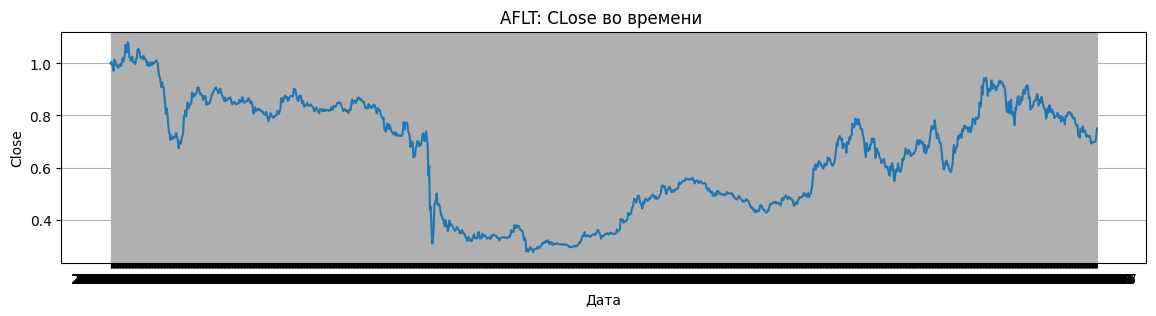

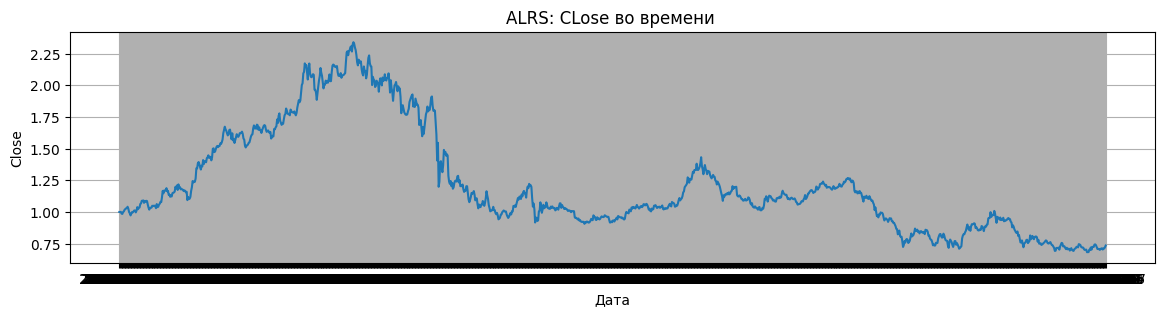

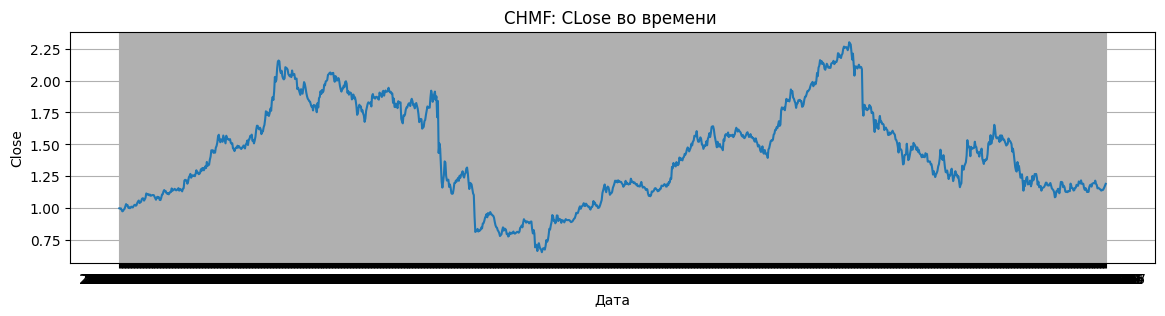

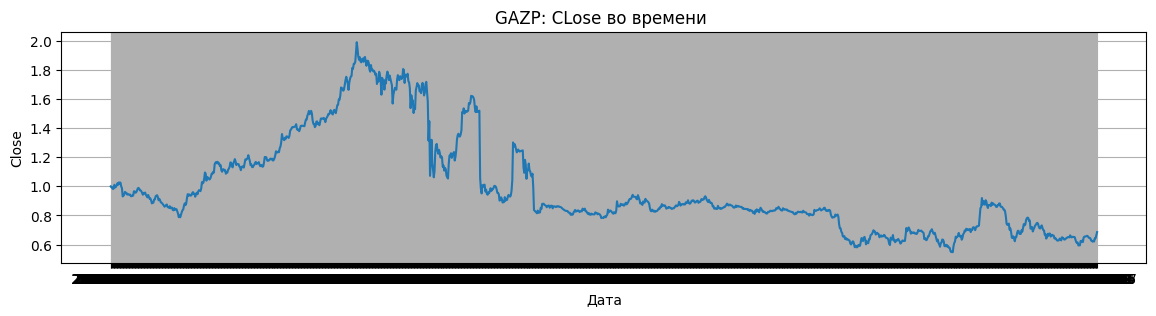

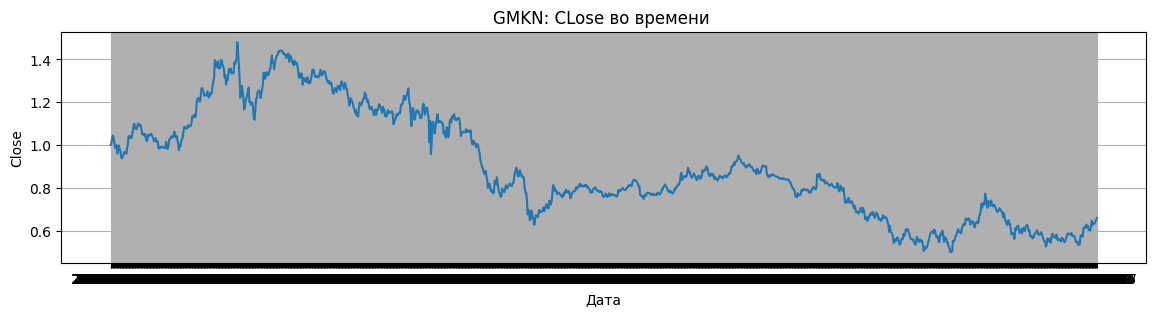

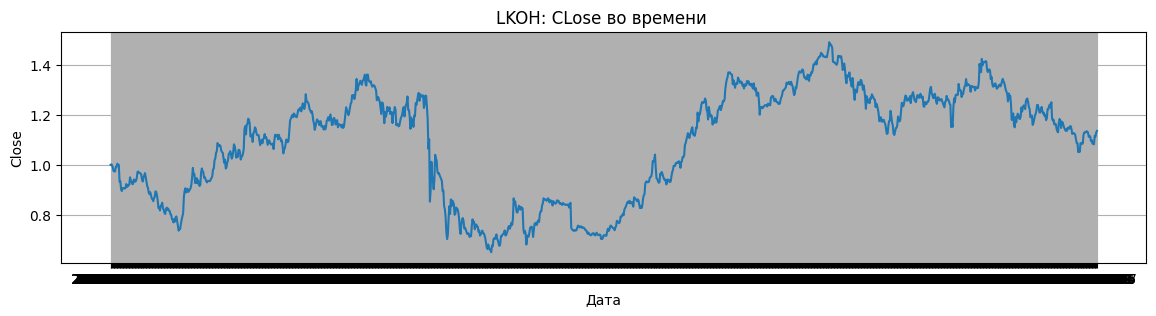

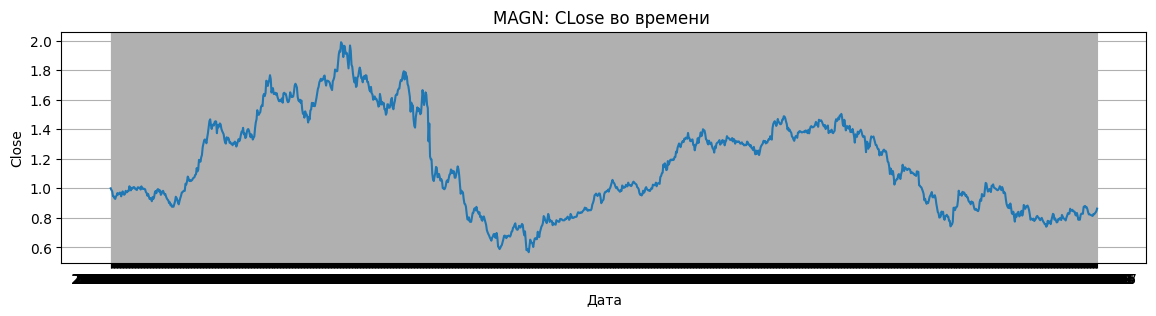

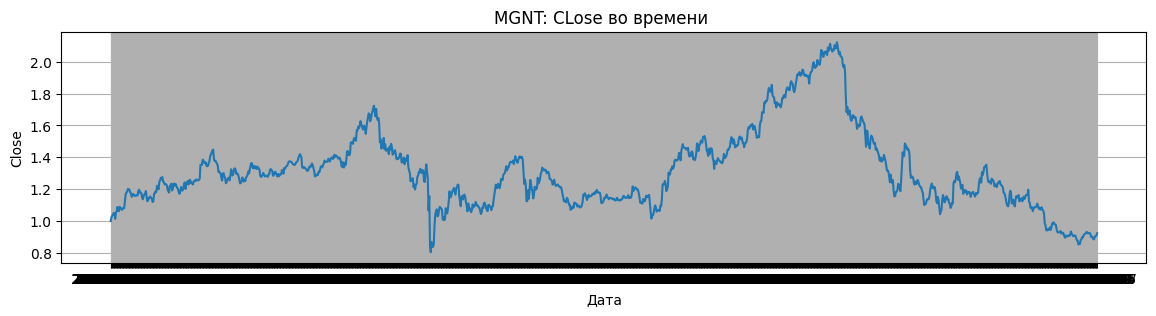

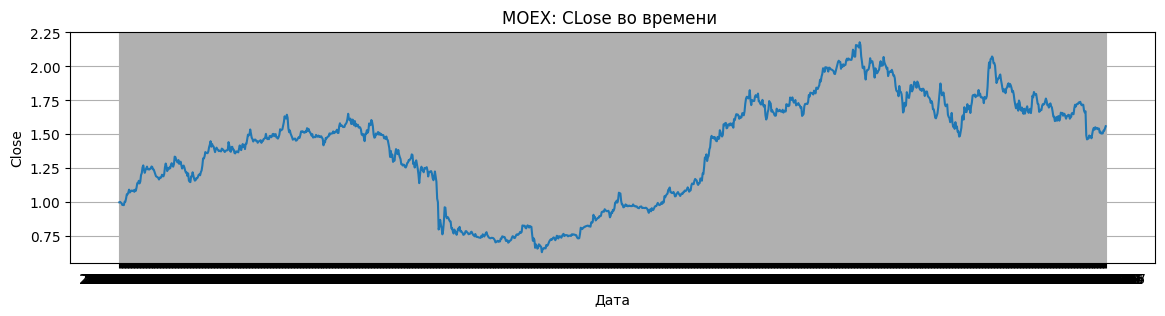

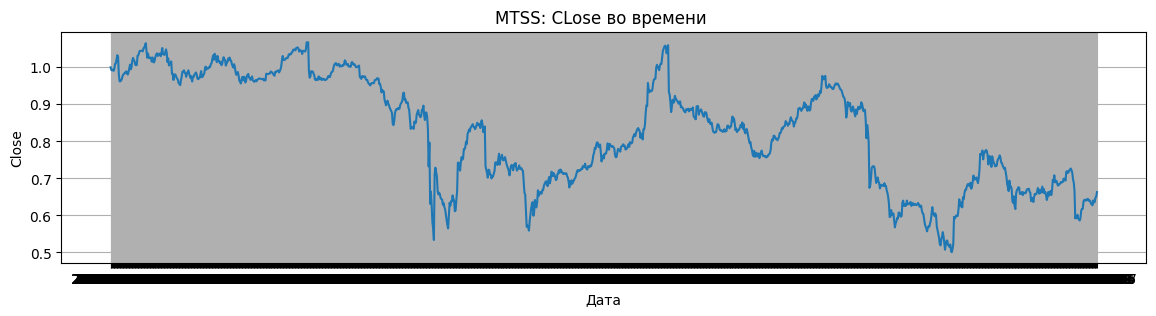

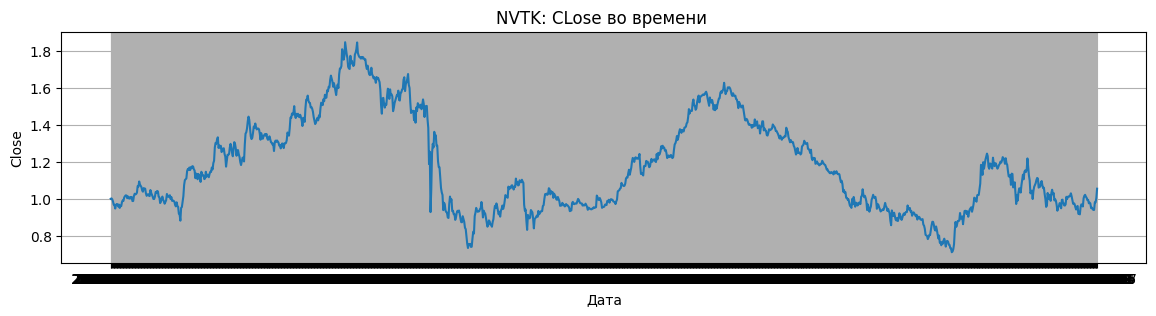

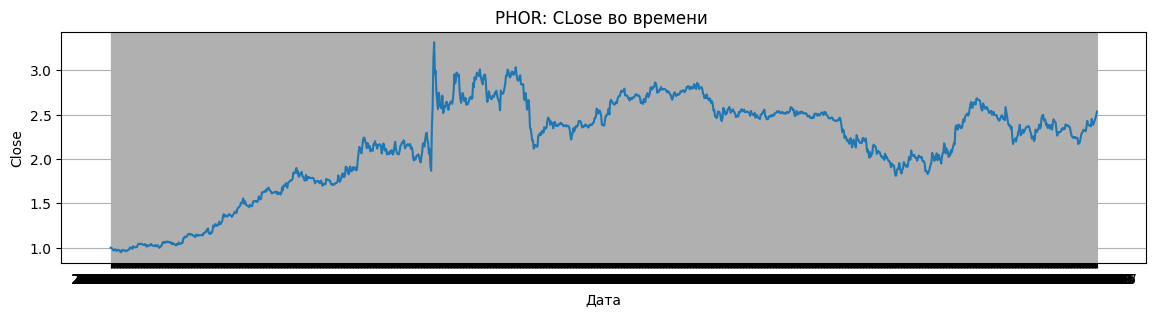

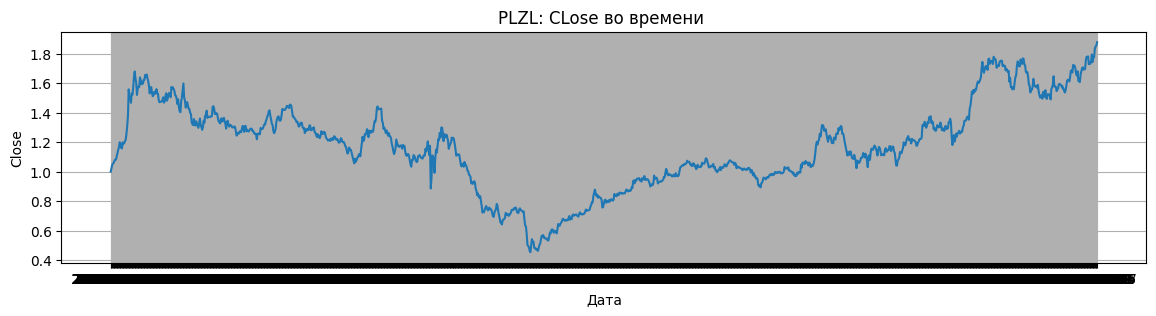

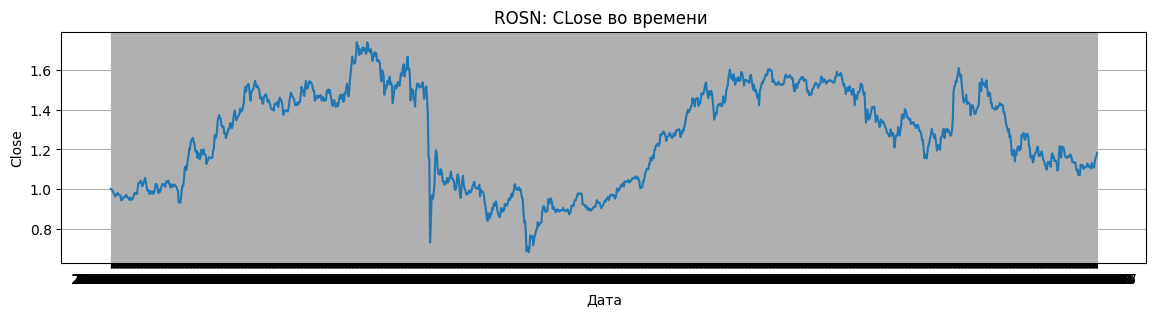

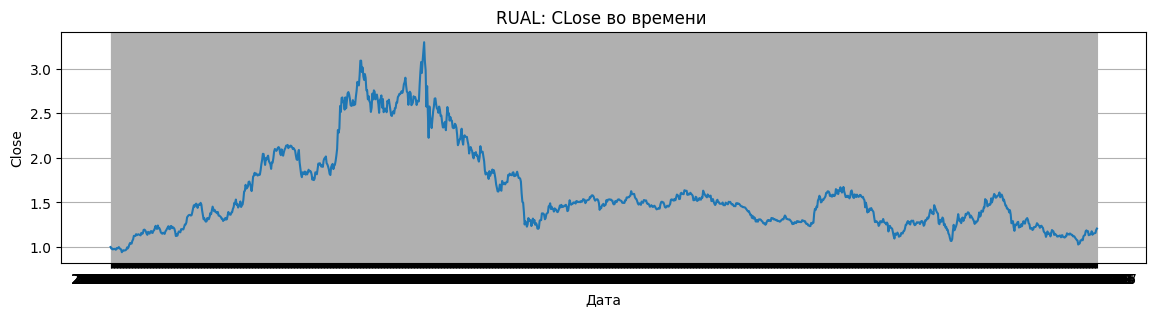

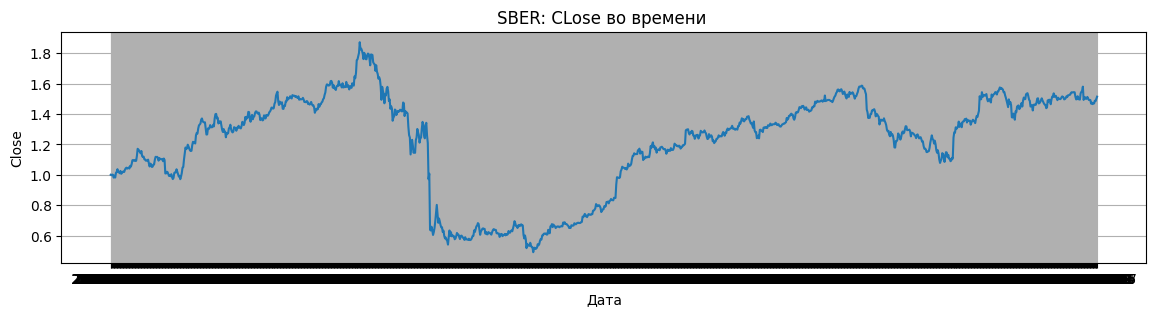

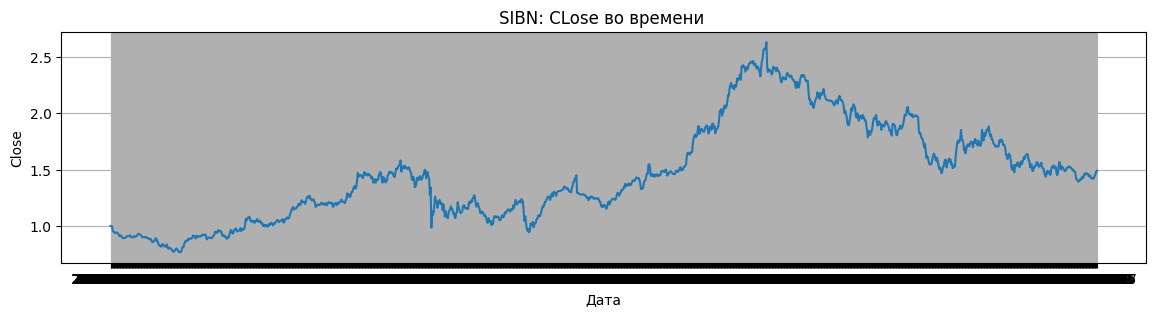

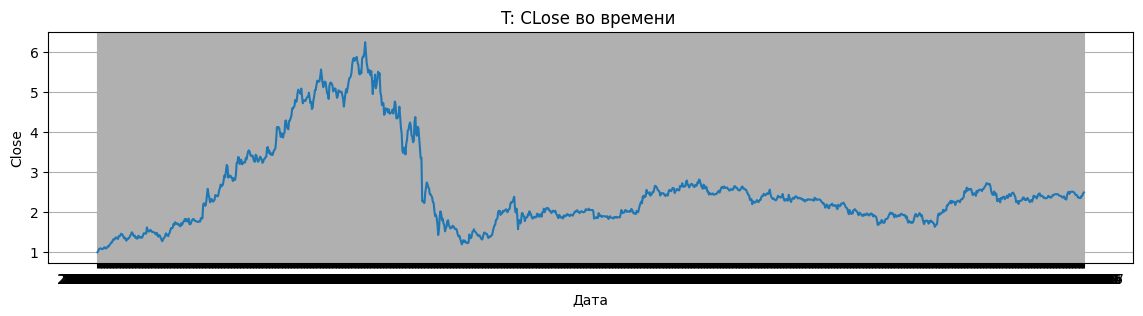

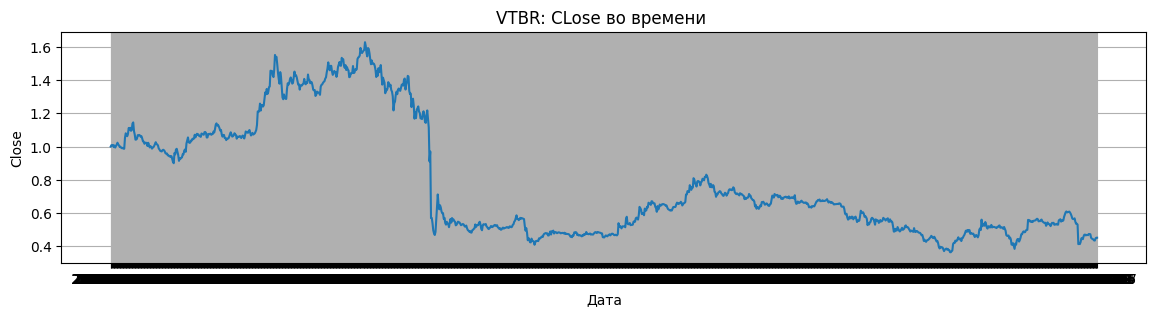

In [ ]:
for ticker in df_processed['ticker'].unique():
    plt.figure(figsize=(14,3))
    df_tic = df_processed[df_processed['ticker'] == ticker].sort_values('date')
    plt.plot(df_tic['date'], df_tic['close'])
    plt.title(f'{ticker}: CLose во времени ')
    plt.xlabel("Дата")
    plt.ylabel("Close")
    plt.grid()
    plt.show()

In [7]:
df_processed['ticker'].value_counts()

ticker
AFLT    1338
ALRS    1338
CHMF    1338
GAZP    1338
LKOH    1338
MAGN    1338
MGNT    1338
MOEX    1338
ROSN    1338
SBER    1338
MTSS    1337
NVTK    1336
PLZL    1335
GMKN    1334
PHOR    1334
RUAL    1334
VTBR    1334
SIBN    1332
T       1316
Name: count, dtype: int64

Всех примерно поровну, возьмём разнообразные тикеры в train и в test
Пусть в test пойдут VTBR, LKOH, RUAL, CHMF

In [8]:
sentiment_cols = ['sentiment_score', 'sentiment_label', 'positive_prob', 'neutral_prob', 'negative_prob', 'confidence']

features = [col for col in df_processed.columns if col not in [f'target_{i}' for i in range(1, 31)] + ['date']]
targets = [f'target_{i}' for i in range(1, 31)]

test_tickers = ['VTBR', 'LKOH', 'RUAL', 'CHMF']

test_df = df_processed[df_processed['ticker'].isin(test_tickers)]
train_df = df_processed[~df_processed['ticker'].isin(test_tickers)]

X_train = train_df[features]
y_train = train_df[targets]

X_test = test_df[features]
y_test = test_df[targets]


0:	learn: 0.5674651	total: 40.6ms	remaining: 40.6s
100:	learn: 0.0418528	total: 3.91s	remaining: 34.8s
200:	learn: 0.0378176	total: 8.19s	remaining: 32.5s
300:	learn: 0.0355607	total: 12.6s	remaining: 29.3s
400:	learn: 0.0338759	total: 16.4s	remaining: 24.5s
500:	learn: 0.0326193	total: 20.8s	remaining: 20.7s
600:	learn: 0.0313088	total: 25s	remaining: 16.6s
700:	learn: 0.0303738	total: 29.1s	remaining: 12.4s
800:	learn: 0.0295743	total: 34.1s	remaining: 8.48s
900:	learn: 0.0288795	total: 38.2s	remaining: 4.19s
999:	learn: 0.0282509	total: 42.2s	remaining: 0us
MAE_sentiment для горизонта 1: 0.0275
0:	learn: 0.5678108	total: 43.4ms	remaining: 43.3s
100:	learn: 0.0522363	total: 4.82s	remaining: 42.9s
200:	learn: 0.0477119	total: 8.78s	remaining: 34.9s
300:	learn: 0.0449829	total: 12.7s	remaining: 29.6s
400:	learn: 0.0430651	total: 17.6s	remaining: 26.4s
500:	learn: 0.0414021	total: 21.6s	remaining: 21.5s
600:	learn: 0.0401100	total: 25.5s	remaining: 16.9s
700:	learn: 0.0388975	total: 30.

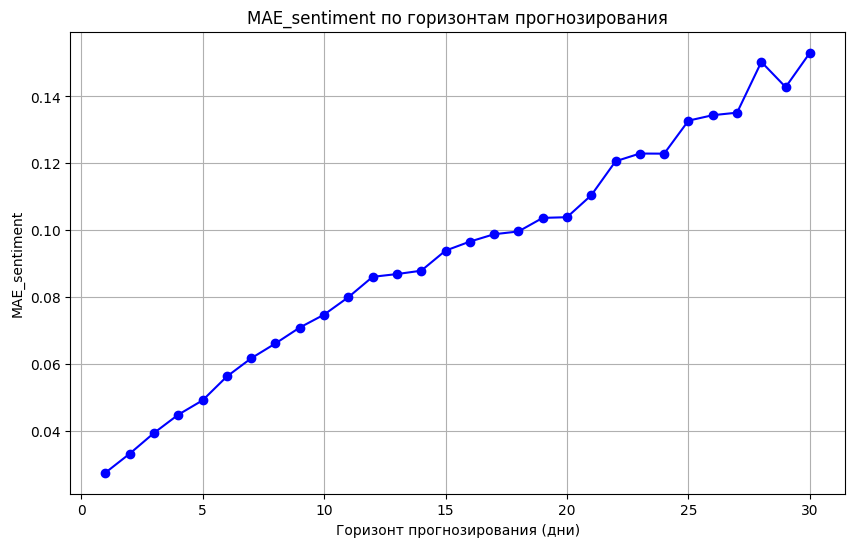

In [10]:
mae_results_sentiment = {}
models = {}
predictions = {}

for horizon in range(1, 31):
    target_col = f'target_{horizon}'
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=10,
        loss_function='RMSE',
        random_seed=42,
        verbose=100,
        cat_features=['ticker']

    )
    model.fit(X_train, y_train[target_col])
    models[horizon] = model

    y_pred = model.predict(X_test)
    predictions[horizon] = y_pred
    mae = mean_absolute_error(y_test[target_col], y_pred)
    mae_results_sentiment[horizon] = mae
    print(f"MAE_sentiment для горизонта {horizon}: {mae:.4f}")

horizons = list(mae_results_sentiment.keys())
mae_values = list(mae_results_sentiment.values())

plt.figure(figsize=(10, 6))
plt.plot(horizons, mae_values, marker='o', linestyle='-', color='b')
plt.title("MAE_sentiment по горизонтам прогнозирования")
plt.xlabel("Горизонт прогнозирования (дни)")
plt.ylabel("MAE_sentiment")
plt.grid(True)
plt.show()

Также попробуем посмотреть на разницу с обучением без анализа новостей

0:	learn: 0.5703491	total: 5.74ms	remaining: 5.74s
100:	learn: 0.0462632	total: 485ms	remaining: 4.32s
200:	learn: 0.0430695	total: 917ms	remaining: 3.64s
300:	learn: 0.0412372	total: 1.39s	remaining: 3.23s
400:	learn: 0.0401657	total: 1.85s	remaining: 2.77s
500:	learn: 0.0393083	total: 2.31s	remaining: 2.31s
600:	learn: 0.0386029	total: 2.77s	remaining: 1.84s
700:	learn: 0.0379996	total: 3.22s	remaining: 1.38s
800:	learn: 0.0374665	total: 3.67s	remaining: 911ms
900:	learn: 0.0369933	total: 4.11s	remaining: 451ms
999:	learn: 0.0366189	total: 4.55s	remaining: 0us
MAE для горизонта 1: 0.0267
0:	learn: 0.5706741	total: 5.15ms	remaining: 5.14s
100:	learn: 0.0567300	total: 457ms	remaining: 4.07s
200:	learn: 0.0534642	total: 928ms	remaining: 3.69s
300:	learn: 0.0516129	total: 1.86s	remaining: 4.33s
400:	learn: 0.0503634	total: 3.05s	remaining: 4.56s
500:	learn: 0.0494735	total: 3.71s	remaining: 3.69s
600:	learn: 0.0487258	total: 4.17s	remaining: 2.77s
700:	learn: 0.0480709	total: 4.63s	remai

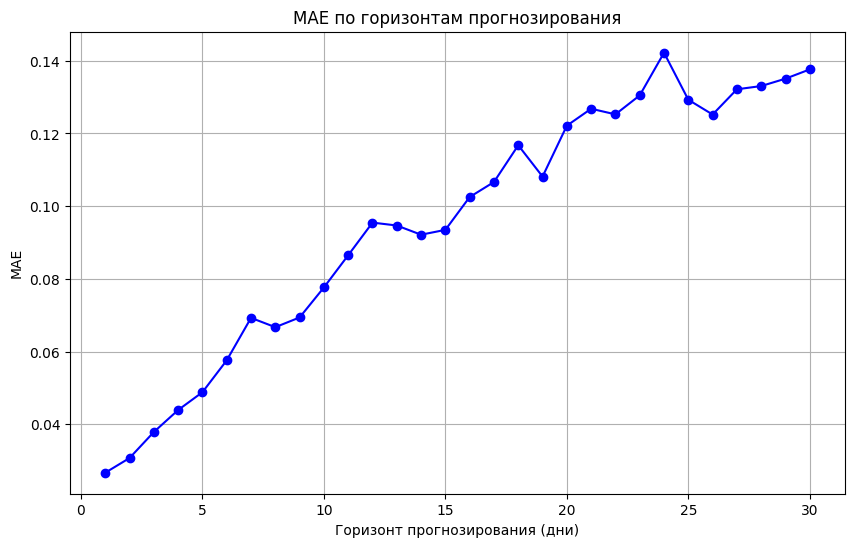

In [11]:
features = [col for col in df_processed.columns if col not in [f'target_{i}' for i in range(1, 31)] + sentiment_cols + ['date']]
targets = [f'target_{i}' for i in range(1, 31)]

features

test_tickers = ['VTBR', 'LKOH', 'RUAL', 'CHMF']

test_df = df_processed[df_processed['ticker'].isin(test_tickers)]
train_df = df_processed[~df_processed['ticker'].isin(test_tickers)]

X_train = train_df[features]
y_train = train_df[targets]

X_test = test_df[features]
y_test = test_df[targets]

mae_results = {}
models = {}
predictions = {}

for horizon in range(1, 31):
    target_col = f'target_{horizon}'
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=4,
        loss_function='RMSE',
        random_seed=42,
        verbose=100,
        cat_features=['ticker']
    )
    model.fit(X_train, y_train[target_col])
    models[horizon] = model

    y_pred = model.predict(X_test)
    predictions[horizon] = y_pred
    mae = mean_absolute_error(y_test[target_col], y_pred)
    mae_results[horizon] = mae
    print(f"MAE для горизонта {horizon}: {mae:.4f}")

horizons = list(mae_results.keys())
mae_values = list(mae_results.values())

plt.figure(figsize=(10, 6))
plt.plot(horizons, mae_values, marker='o', linestyle='-', color='b')
plt.title("MAE по горизонтам прогнозирования")
plt.xlabel("Горизонт прогнозирования (дни)")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

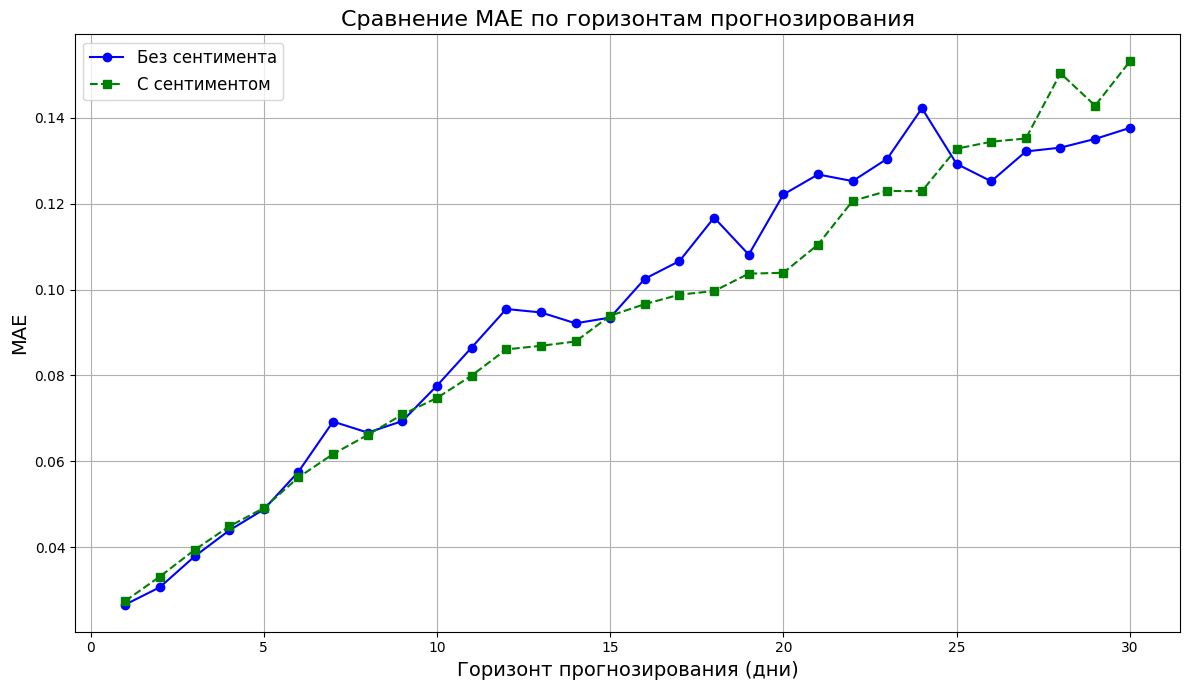

In [12]:
horizons = list(mae_results.keys())
mae_values = list(mae_results.values())
mae_values_sentiment = list(mae_results_sentiment.values())

plt.figure(figsize=(12, 7))
plt.plot(horizons, mae_values, marker='o', linestyle='-', color='blue', label='Без сентимента')
plt.plot(horizons, mae_values_sentiment, marker='s', linestyle='--', color='green', label='С сентиментом')

plt.title("Сравнение MAE по горизонтам прогнозирования", fontsize=16)
plt.xlabel("Горизонт прогнозирования (дни)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# Более оптимизированный вариант

In [13]:
df = pd.read_csv("/content/news_analysis_complete.csv")

In [14]:
days_horis = 30
test_tikers = ['SBER','SIBN','T','VTBR'] # допустим возьмем эти тикеры


тут мы понимаем что кетбуст неплохо справляется с прогнозированием. Нам нужно его оптимизировать

In [15]:

test_n_days = 90

In [16]:
CB_PARAMS = dict(
    iterations=2000,
    learning_rate=0.05,
    depth=10,
    loss_function="RMSE",
    random_seed=42,
    verbose=200
)
EARLY_STOPPING_ROUNDS = 200

In [17]:
if "date" not in df.columns:
    raise ValueError("нет колонки 'date'.")

In [18]:

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).copy()

df = df.sort_values(["date", "ticker"] if "ticker" in df.columns else ["date"]).reset_index(drop=True)


добавление новых фичей. Пункт 2.2 iшаг 3

In [21]:

df["month"] = df["date"].dt.month
df["weekday"] = df["date"].dt.weekday

df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
df["weekday_sin"] = np.sin(2 * np.pi * df["weekday"] / 7)
df["weekday_cos"] = np.cos(2 * np.pi * df["weekday"] / 7)


In [22]:
price_volume_cols = ['open', 'close', 'high', 'low', 'volume']
def normalize_by_first_value(group):
    first_values = group[price_volume_cols].iloc[0]
    group[price_volume_cols] = group[price_volume_cols].div(first_values)
    return group

df = df.groupby('ticker', group_keys=False).apply(normalize_by_first_value)

for i in range(1, days_horis + 1):
    df[f'target_{i}'] = df.groupby('ticker')['close'].shift(-i)
df.dropna(subset=[f'target_{i}' for i in range(1, days_horis + 1)], inplace=True)

/tmp/ipython-input-2999598026.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('ticker', group_keys=False).apply(normalize_by_first_value)


In [23]:
base_features = ["open", "close", "high", "low", "volume", "ticker"]

sentiment_cols = ["sentiment_score","sentiment_label","positive_prob","neutral_prob","negative_prob","confidence"]




In [24]:
cyclical_features = ["month_sin", "month_cos", "weekday_sin", "weekday_cos"]

features = base_features + sentiment_cols + cyclical_features
targets = [f"target_{i}" for i in range(1, days_horis + 1)]


In [25]:
required_cols = set(features + targets + ["date"])
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Не хватает колонок в датасете: {missing}")

In [26]:


df["ticker"] = df["ticker"].astype(str)

df["sentiment_label"] = df["sentiment_label"].fillna("unknown").astype(str)

for c in ["sentiment_score", "positive_prob", "neutral_prob", "negative_prob", "confidence"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
# в целом кетбуст умеет работать с нанами но это даст большую стабильность
num_cols = [c for c in features if c not in ["ticker", "sentiment_label"]]
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

cat_features = ["ticker", "sentiment_label"]

In [27]:
max_date = df["date"].max()
cutoff = max_date - pd.Timedelta(days=test_n_days)

time_test_df = df[df["date"] > cutoff].copy()
time_train_df = df[df["date"] <= cutoff].copy()


In [28]:

if len(time_test_df) < 50 or len(time_train_df) < 200:
    test_df = df[df["ticker"].isin(test_tikers)].copy()
    train_df = df[~df["ticker"].isin(test_tikers)].copy()
else:
    print(f" time-split: test после {cutoff.date()} (max_date={max_date.date()})")
    test_df = time_test_df
    train_df = time_train_df

 time-split: test после 2025-05-09 (max_date=2025-08-07)


In [29]:

X_train = train_df[features]
y_train = train_df[targets]

X_test = test_df[features]
y_test = test_df[targets]

mae_by_horizon = {}
models = {}
preds = {}

for h in range(1, days_horis + 1):
    target_col = f"target_{h}"
    model = CatBoostRegressor(**CB_PARAMS)

    model.fit(
        X_train,
        y_train[target_col],
        cat_features=[c for c in cat_features if c in X_train.columns],
        eval_set=(X_test, y_test[target_col]),
        use_best_model=True,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS
    )

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test[target_col], y_pred)

    models[h] = model
    preds[h] = y_pred
    mae_by_horizon[h] = mae

    print(f"Horizon {h:02d}: MAE = {mae:.4f}")


0:	learn: 0.5743609	test: 0.5169012	best: 0.5169012 (0)	total: 52.5ms	remaining: 1m 44s
200:	learn: 0.0362031	test: 0.0234606	best: 0.0234606 (200)	total: 11s	remaining: 1m 38s
400:	learn: 0.0321147	test: 0.0223675	best: 0.0223657 (399)	total: 21.2s	remaining: 1m 24s
600:	learn: 0.0291820	test: 0.0220718	best: 0.0220614 (564)	total: 32.7s	remaining: 1m 16s
800:	learn: 0.0270641	test: 0.0219440	best: 0.0219023 (746)	total: 44.2s	remaining: 1m 6s
1000:	learn: 0.0253767	test: 0.0219358	best: 0.0218684 (844)	total: 55.4s	remaining: 55.3s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.02186841228
bestIteration = 844

Shrink model to first 845 iterations.
Horizon 01: MAE = 0.0152
0:	learn: 0.5745520	test: 0.5176635	best: 0.5176635 (0)	total: 50.7ms	remaining: 1m 41s
200:	learn: 0.0459408	test: 0.0309038	best: 0.0308739 (181)	total: 11.1s	remaining: 1m 39s
400:	learn: 0.0410532	test: 0.0307668	best: 0.0306903 (281)	total: 21.9s	remaining: 1m 27s
Stopped by overfitting de


MAE summary:
   horizon       mae
0        1  0.015183
1        2  0.022093
2        3  0.026304
3        4  0.030679
4        5  0.034081
5        6  0.038307
6        7  0.041858
7        8  0.043768
8        9  0.045062
9       10  0.047723


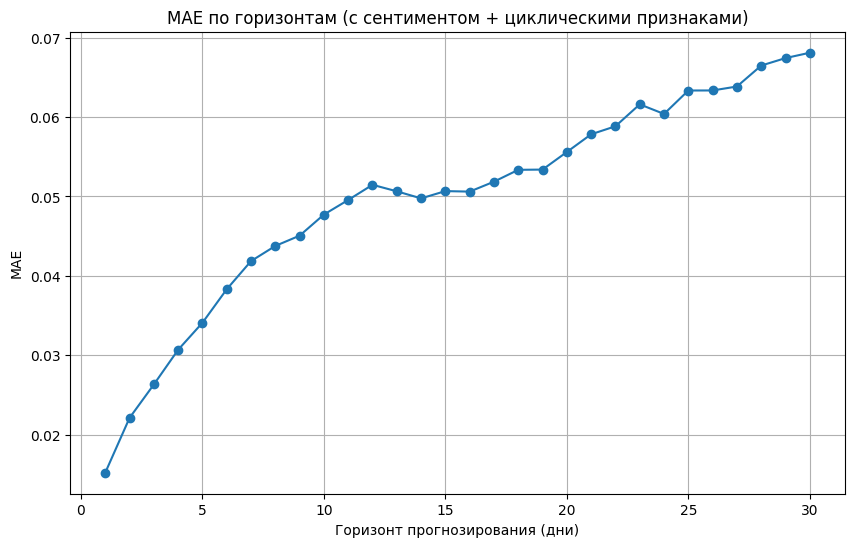

In [30]:
results_df = pd.DataFrame({
    "horizon": list(mae_by_horizon.keys()),
    "mae": list(mae_by_horizon.values())
}).sort_values("horizon")

print("\nMAE summary:")
print(results_df.head(10))

plt.figure(figsize=(10, 6))
plt.plot(results_df["horizon"], results_df["mae"], marker="o", linestyle="-")
plt.title("MAE по горизонтам (с сентиментом + циклическими признаками)")
plt.xlabel("Горизонт прогнозирования (дни)")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

In [31]:
print(df['ticker'].unique())

['AFLT' 'ALRS' 'CHMF' 'GAZP' 'GMKN' 'LKOH' 'MAGN' 'MGNT' 'MOEX' 'MTSS'
 'NVTK' 'PHOR' 'PLZL' 'ROSN' 'RUAL' 'SBER' 'SIBN' 'T' 'VTBR']


Training Random Forest for Horizon 01...
Horizon 01: R2 Score = 0.9986, MAE = 0.0128
Training Random Forest for Horizon 02...
Horizon 02: R2 Score = 0.9971, MAE = 0.0202
Training Random Forest for Horizon 03...
Horizon 03: R2 Score = 0.9954, MAE = 0.0259
Training Random Forest for Horizon 04...
Horizon 04: R2 Score = 0.9936, MAE = 0.0310
Training Random Forest for Horizon 05...
Horizon 05: R2 Score = 0.9914, MAE = 0.0357
Training Random Forest for Horizon 06...
Horizon 06: R2 Score = 0.9895, MAE = 0.0392
Training Random Forest for Horizon 07...
Horizon 07: R2 Score = 0.9869, MAE = 0.0439
Training Random Forest for Horizon 08...
Horizon 08: R2 Score = 0.9846, MAE = 0.0475
Training Random Forest for Horizon 09...
Horizon 09: R2 Score = 0.9826, MAE = 0.0513
Training Random Forest for Horizon 10...
Horizon 10: R2 Score = 0.9813, MAE = 0.0531
Training Random Forest for Horizon 11...
Horizon 11: R2 Score = 0.9815, MAE = 0.0534
Training Random Forest for Horizon 12...
Horizon 12: R2 Score = 0

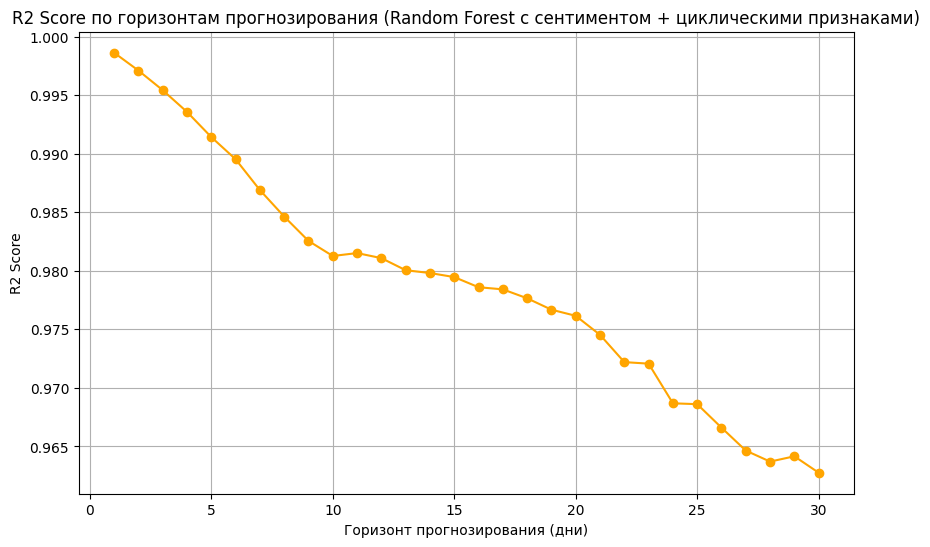

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

r2_results_rf = {}
mae_results_rf = {}
models_rf = {}
predictions_rf = {}


RF_PARAMS = dict(
    n_estimators=100,
    max_depth=10,
    random_state=41,
    n_jobs=-1
)


for h in range(1, days_horis + 1):
    target_col = f"target_{h}"
    print(f"Training Random Forest for Horizon {h:02d}...")

    model_rf = RandomForestRegressor(**RF_PARAMS)
    X_train_rf = X_train.copy()
    X_test_rf = X_test.copy()

    rf_cat_features = [col for col in cat_features if col in X_train_rf.columns and X_train_rf[col].dtype == 'object']

    if rf_cat_features:
        X_train_rf = pd.get_dummies(X_train_rf, columns=rf_cat_features, drop_first=True)
        X_test_rf = pd.get_dummies(X_test_rf, columns=rf_cat_features, drop_first=True)

        train_cols = set(X_train_rf.columns)
        test_cols = set(X_test_rf.columns)

        missing_in_test = list(train_cols - test_cols)
        for c in missing_in_test:
            X_test_rf[c] = 0

        missing_in_train = list(test_cols - train_cols)
        for c in missing_in_train:
            X_train_rf[c] = 0

        X_test_rf = X_test_rf[X_train_rf.columns]

    model_rf.fit(X_train_rf, y_train[target_col])
    models_rf[h] = model_rf

    y_pred_rf = model_rf.predict(X_test_rf)
    predictions_rf[h] = y_pred_rf

    r2 = r2_score(y_test[target_col], y_pred_rf)
    mae = mean_absolute_error(y_test[target_col], y_pred_rf)

    r2_results_rf[h] = r2
    mae_results_rf[h] = mae

    print(f"Horizon {h:02d}: R2 Score = {r2:.4f}, MAE = {mae:.4f}")

r2_results_df_rf = pd.DataFrame({
    "horizon": list(r2_results_rf.keys()),
    "r2_score": list(r2_results_rf.values())
}).sort_values("horizon")

print(r2_results_df_rf.head(10))

plt.figure(figsize=(10, 6))
plt.plot(r2_results_df_rf["horizon"], r2_results_df_rf["r2_score"], marker="o", linestyle="-", color='orange')
plt.title("R2 Score по горизонтам прогнозирования (Random Forest с сентиментом + циклическими признаками)")
plt.xlabel("Горизонт прогнозирования (дни)")
plt.ylabel("R2 Score")
plt.grid(True)
plt.show()

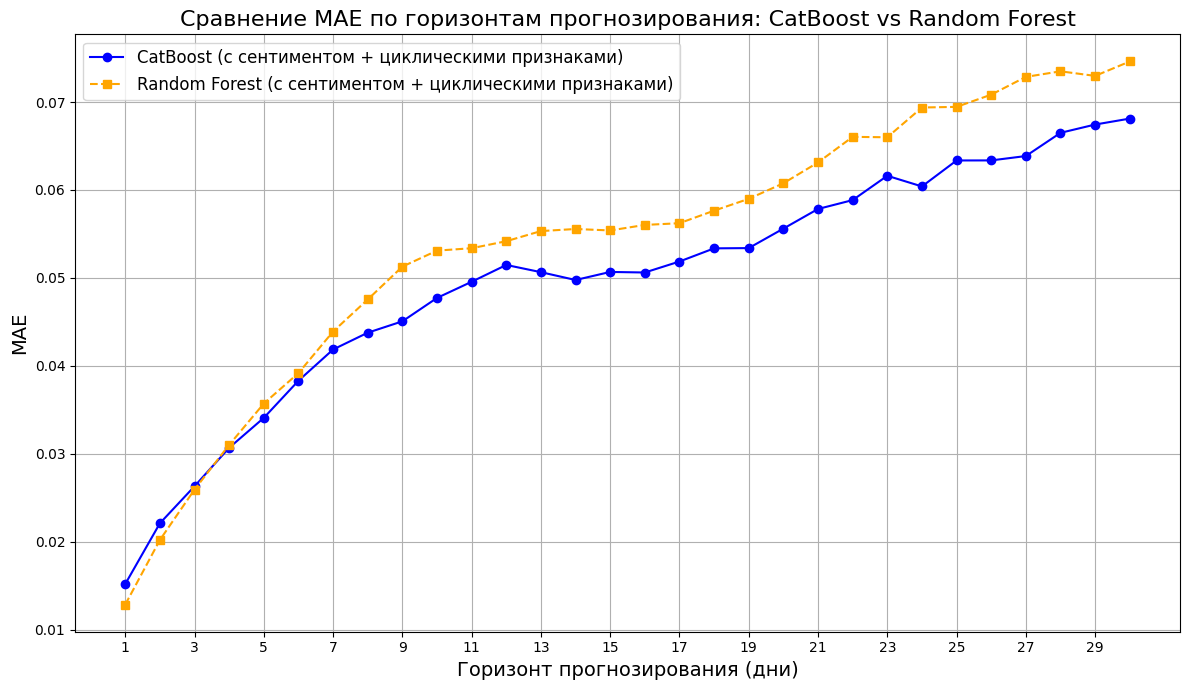


--- Сводка MAE: CatBoost vs Random Forest ---
   Horizon  MAE CatBoost  MAE Random Forest
0        1      0.015183           0.012846
1        2      0.022093           0.020196
2        3      0.026304           0.025928
3        4      0.030679           0.031012
4        5      0.034081           0.035711
5        6      0.038307           0.039174
6        7      0.041858           0.043903
7        8      0.043768           0.047545
8        9      0.045062           0.051286
9       10      0.047723           0.053104
    Horizon  MAE CatBoost  MAE Random Forest
20       21      0.057842           0.063133
21       22      0.058851           0.066044
22       23      0.061616           0.065996
23       24      0.060404           0.069382
24       25      0.063358           0.069454
25       26      0.063365           0.070844
26       27      0.063862           0.072864
27       28      0.066501           0.073498
28       29      0.067445           0.072978
29       30      0.

In [33]:
catboost_mae_df = pd.DataFrame({
    "horizon": list(mae_by_horizon.keys()),
    "mae": list(mae_by_horizon.values())
}).sort_values("horizon")

rf_mae_df = pd.DataFrame({
    "horizon": list(mae_results_rf.keys()),
    "mae": list(mae_results_rf.values())
}).sort_values("horizon")

plt.figure(figsize=(12, 7))
plt.plot(catboost_mae_df["horizon"], catboost_mae_df["mae"], marker='o', linestyle='-', color='blue', label='CatBoost (с сентиментом + циклическими признаками)')
plt.plot(rf_mae_df["horizon"], rf_mae_df["mae"], marker='s', linestyle='--', color='orange', label='Random Forest (с сентиментом + циклическими признаками)')

plt.title("Сравнение MAE по горизонтам прогнозирования: CatBoost vs Random Forest", fontsize=16)
plt.xlabel("Горизонт прогнозирования (дни)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(1, days_horis + 1, 2))
plt.tight_layout()
plt.show()

print("\n--- Сводка MAE: CatBoost vs Random Forest ---")
comparison_df = pd.DataFrame({
    "Horizon": catboost_mae_df["horizon"],
    "MAE CatBoost": catboost_mae_df["mae"],
    "MAE Random Forest": rf_mae_df["mae"]
})
print(comparison_df.head(10))
print(comparison_df.tail(10))

In [34]:
from sklearn.linear_model import Ridge

In [42]:
mae_results_ridge = {}
models_ridge = {}
predictions_ridge = {}

for i in range(5, 30, 5):

  RIDGE_PARAMS = {
      'alpha': i//10,  #
      'random_state': 42
  }

  for h in range(1, days_horis + 1):
      target_col = f"target_{h}"
      print(f"Training Ridge for Horizon {h:02d}...")

      model_ridge = Ridge(**RIDGE_PARAMS)

      model_ridge.fit(X_train_rf, y_train[target_col])
      models_ridge[h] = model_ridge

      y_pred_ridge = model_ridge.predict(X_test_rf)
      predictions_ridge[h] = y_pred_ridge

      mae = mean_absolute_error(y_test[target_col], y_pred_ridge)
      mae_results_ridge[h] = mae

      print(f"Horizon {h:02d}: MAE = {mae:.4f}")

Training Ridge for Horizon 01...
Horizon 01: MAE = 0.0122
Training Ridge for Horizon 02...
Horizon 02: MAE = 0.0192
Training Ridge for Horizon 03...
Horizon 03: MAE = 0.0241
Training Ridge for Horizon 04...
Horizon 04: MAE = 0.0288
Training Ridge for Horizon 05...
Horizon 05: MAE = 0.0322
Training Ridge for Horizon 06...
Horizon 06: MAE = 0.0360
Training Ridge for Horizon 07...
Horizon 07: MAE = 0.0392
Training Ridge for Horizon 08...
Horizon 08: MAE = 0.0415
Training Ridge for Horizon 09...
Horizon 09: MAE = 0.0439
Training Ridge for Horizon 10...
Horizon 10: MAE = 0.0461
Training Ridge for Horizon 11...


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/pytho

Horizon 11: MAE = 0.0479
Training Ridge for Horizon 12...
Horizon 12: MAE = 0.0490
Training Ridge for Horizon 13...
Horizon 13: MAE = 0.0492
Training Ridge for Horizon 14...
Horizon 14: MAE = 0.0497
Training Ridge for Horizon 15...
Horizon 15: MAE = 0.0493
Training Ridge for Horizon 16...
Horizon 16: MAE = 0.0490
Training Ridge for Horizon 17...
Horizon 17: MAE = 0.0492
Training Ridge for Horizon 18...
Horizon 18: MAE = 0.0495
Training Ridge for Horizon 19...
Horizon 19: MAE = 0.0508
Training Ridge for Horizon 20...
Horizon 20: MAE = 0.0525
Training Ridge for Horizon 21...
Horizon 21: MAE = 0.0538
Training Ridge for Horizon 22...
Horizon 22: MAE = 0.0554
Training Ridge for Horizon 23...
Horizon 23: MAE = 0.0569
Training Ridge for Horizon 24...
Horizon 24: MAE = 0.0586
Training Ridge for Horizon 25...


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/pytho

Horizon 25: MAE = 0.0599
Training Ridge for Horizon 26...
Horizon 26: MAE = 0.0614
Training Ridge for Horizon 27...
Horizon 27: MAE = 0.0628
Training Ridge for Horizon 28...
Horizon 28: MAE = 0.0643
Training Ridge for Horizon 29...
Horizon 29: MAE = 0.0657
Training Ridge for Horizon 30...
Horizon 30: MAE = 0.0666
Training Ridge for Horizon 01...
Horizon 01: MAE = 0.0123
Training Ridge for Horizon 02...
Horizon 02: MAE = 0.0192
Training Ridge for Horizon 03...
Horizon 03: MAE = 0.0241
Training Ridge for Horizon 04...
Horizon 04: MAE = 0.0287
Training Ridge for Horizon 05...
Horizon 05: MAE = 0.0322
Training Ridge for Horizon 06...
Horizon 06: MAE = 0.0360
Training Ridge for Horizon 07...
Horizon 07: MAE = 0.0392
Training Ridge for Horizon 08...
Horizon 08: MAE = 0.0416
Training Ridge for Horizon 09...


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.25756e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Horizon 09: MAE = 0.0439
Training Ridge for Horizon 10...
Horizon 10: MAE = 0.0461
Training Ridge for Horizon 11...
Horizon 11: MAE = 0.0479
Training Ridge for Horizon 12...
Horizon 12: MAE = 0.0489
Training Ridge for Horizon 13...
Horizon 13: MAE = 0.0491
Training Ridge for Horizon 14...
Horizon 14: MAE = 0.0495
Training Ridge for Horizon 15...
Horizon 15: MAE = 0.0491
Training Ridge for Horizon 16...
Horizon 16: MAE = 0.0488
Training Ridge for Horizon 17...
Horizon 17: MAE = 0.0490
Training Ridge for Horizon 18...
Horizon 18: MAE = 0.0494
Training Ridge for Horizon 19...
Horizon 19: MAE = 0.0506
Training Ridge for Horizon 20...
Horizon 20: MAE = 0.0522
Training Ridge for Horizon 21...
Horizon 21: MAE = 0.0536
Training Ridge for Horizon 22...
Horizon 22: MAE = 0.0552
Training Ridge for Horizon 23...
Horizon 23: MAE = 0.0566
Training Ridge for Horizon 24...
Horizon 24: MAE = 0.0584
Training Ridge for Horizon 25...
Horizon 25: MAE = 0.0597
Training Ridge for Horizon 26...
Horizon 26: MA

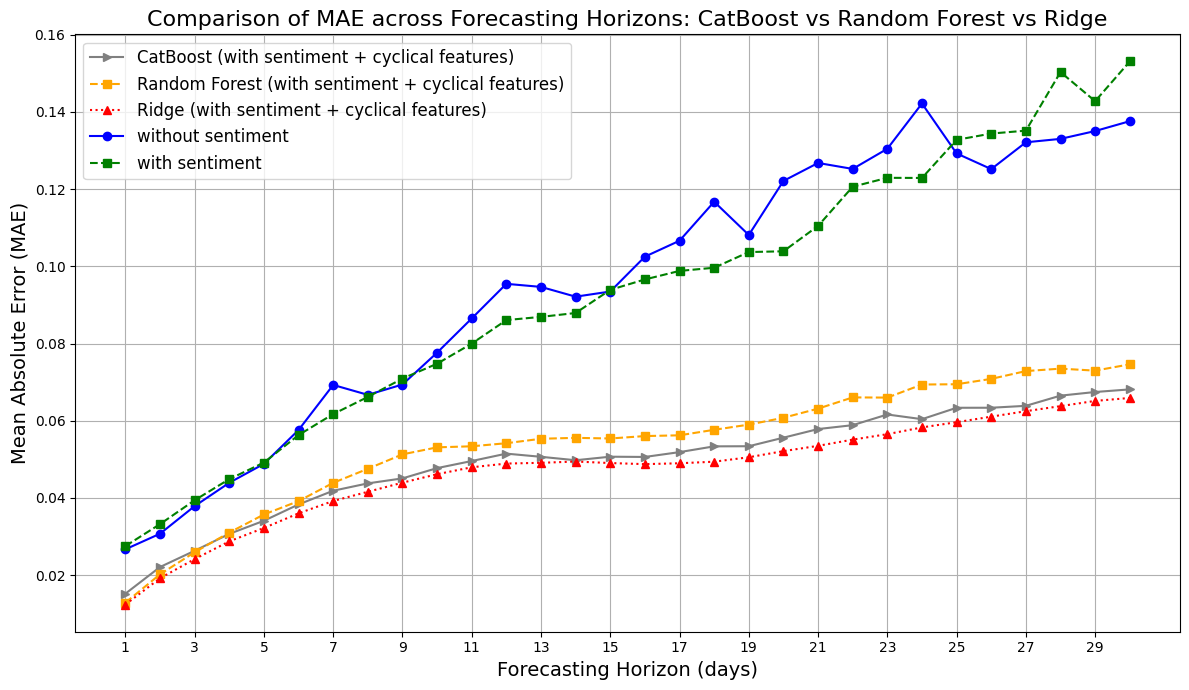

   Horizon  MAE CatBoost  MAE Random Forest  MAE Ridge
0        1      0.015183           0.012846   0.012365
1        2      0.022093           0.020196   0.019180
2        3      0.026304           0.025928   0.024146
3        4      0.030679           0.031012   0.028750
4        5      0.034081           0.035711   0.032207
5        6      0.038307           0.039174   0.036003
6        7      0.041858           0.043903   0.039203
7        8      0.043768           0.047545   0.041589
8        9      0.045062           0.051286   0.043950
9       10      0.047723           0.053104   0.046147
    Horizon  MAE CatBoost  MAE Random Forest  MAE Ridge
20       21      0.057842           0.063133   0.053493
21       22      0.058851           0.066044   0.055106
22       23      0.061616           0.065996   0.056516
23       24      0.060404           0.069382   0.058269
24       25      0.063358           0.069454   0.059620
25       26      0.063365           0.070844   0.061055
26 

In [43]:
catboost_mae_df = pd.DataFrame({
    "horizon": list(mae_by_horizon.keys()),
    "mae": list(mae_by_horizon.values())
}).sort_values("horizon")

rf_mae_df = pd.DataFrame({
    "horizon": list(mae_results_rf.keys()),
    "mae": list(mae_results_rf.values())
}).sort_values("horizon")

ridge_mae_df = pd.DataFrame({
    "horizon": list(mae_results_ridge.keys()),
    "mae": list(mae_results_ridge.values())
}).sort_values("horizon")


plt.figure(figsize=(12, 7))
plt.plot(catboost_mae_df["horizon"], catboost_mae_df["mae"], marker='>', linestyle='solid', color='gray', label='CatBoost (with sentiment + cyclical features)')
plt.plot(rf_mae_df["horizon"], rf_mae_df["mae"], marker='s', linestyle='--', color='orange', label='Random Forest (with sentiment + cyclical features)')
plt.plot(ridge_mae_df["horizon"], ridge_mae_df["mae"], marker='^', linestyle=':', color='red', label='Ridge (with sentiment + cyclical features)')
plt.plot(horizons, mae_values, marker='o', linestyle='-', color='blue', label='without sentiment')
plt.plot(horizons, mae_values_sentiment, marker='s', linestyle='--', color='green', label='with sentiment')

plt.title("Comparison of MAE across Forecasting Horizons: CatBoost vs Random Forest vs Ridge", fontsize=16)
plt.xlabel("Forecasting Horizon (days)", fontsize=14)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(1, days_horis + 1, 2))
plt.tight_layout()
plt.show()

comparison_df_all = pd.DataFrame({
    "Horizon": catboost_mae_df["horizon"],
    "MAE CatBoost": catboost_mae_df["mae"],
    "MAE Random Forest": rf_mae_df["mae"],
    "MAE Ridge": ridge_mae_df["mae"]
})
print(comparison_df_all.head(10))
print(comparison_df_all.tail(10))

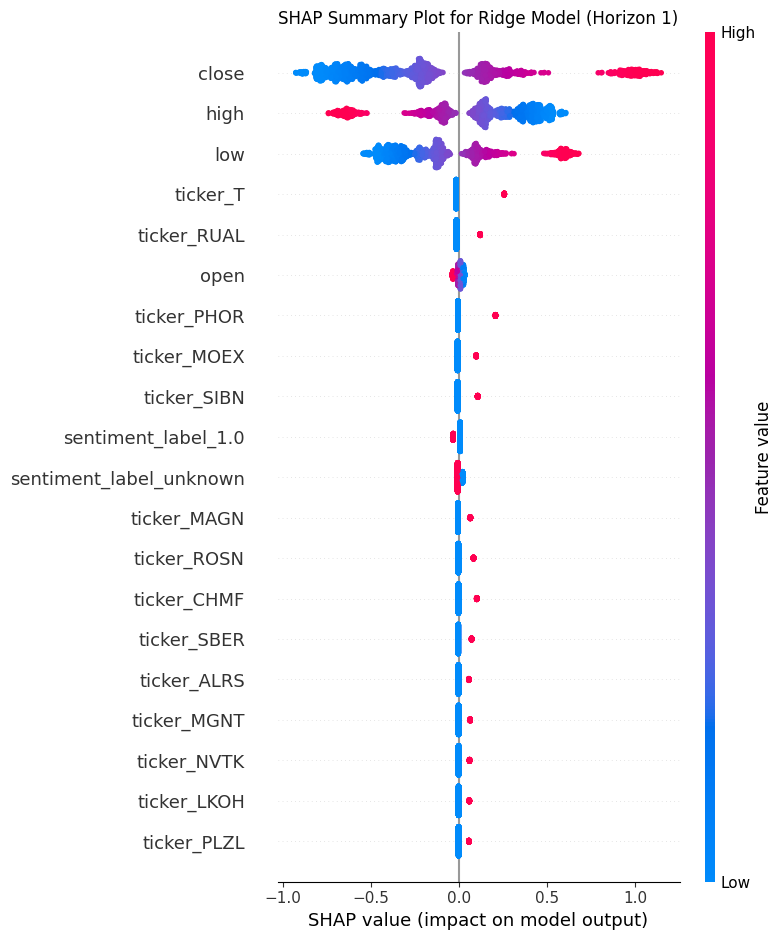

In [52]:
!pip install shap
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

model_to_explain_ridge = models_ridge[1]


def ensure_numeric_df(df_input):
    df_output = df_input.copy()
    for col in df_output.columns:
        if df_output[col].dtype == 'bool':
            df_output[col] = df_output[col].astype(int)
        elif not pd.api.types.is_numeric_dtype(df_output[col]):
            df_output[col] = pd.to_numeric(df_output[col], errors='coerce')
    return df_output.fillna(0)
X_train_rf_numeric = ensure_numeric_df(X_train_rf)
X_test_rf_numeric = ensure_numeric_df(X_test_rf)

explainer_ridge = shap.LinearExplainer(model_to_explain_ridge, X_train_rf_numeric)

shap_values_ridge = explainer_ridge.shap_values(X_test_rf_numeric)

shap_values_ridge = np.asarray(shap_values_ridge, dtype=np.float64)
shap_values_ridge[~np.isfinite(shap_values_ridge)] = 0

shap.summary_plot(shap_values_ridge, X_test_rf_numeric, show=False)
plt.title("SHAP Summary Plot for Ridge Model (Horizon 1)")
plt.tight_layout()
plt.show()

In [63]:
import joblib
model_filename = 'ridge_model_horizon_1.joblib'
joblib.dump(models_ridge[1], model_filename)

Ridge model for horizon 1 saved as ridge_model_horizon_1.joblib


# Построение модели на новом датасете с такой же  обработкой

In [76]:
df = pd.read_csv("/content/itog_dataset.csv")

In [77]:
days_horis = 30
test_tikers = ['SBER','SIBN','T','VTBR'] # допустим возьмем эти тикеры


тут мы понимаем что кетбуст неплохо справляется с прогнозированием. Нам нужно его оптимизировать

In [78]:

test_n_days = 90

In [92]:
CB_PARAMS = dict(
    iterations=2000,
    learning_rate=0.05,
    depth=10,
    loss_function="RMSE",
    random_seed=42,
    verbose=200,
    task_type='GPU'
)
EARLY_STOPPING_ROUNDS = 200

In [80]:
if "date" not in df.columns:
    raise ValueError("нет колонки 'date'.")

In [81]:

df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.dropna(subset=["date"]).copy()

df = df.sort_values(["date", "ticker"] if "ticker" in df.columns else ["date"]).reset_index(drop=True)


добавление новых фичей. Пункт 2.2 iшаг 3

In [ ]:
# уже добавлено в изначальной
# df["month"] = df["date"].dt.month
# df["weekday"] = df["date"].dt.weekday

# df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
# df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
# df["weekday_sin"] = np.sin(2 * np.pi * df["weekday"] / 7)
# df["weekday_cos"] = np.cos(2 * np.pi * df["weekday"] / 7)


In [82]:
price_volume_cols = ['open', 'close', 'high', 'low', 'volume']

In [83]:
base_features = ["open", "close", "high", "low", "volume", "ticker"]

sentiment_cols = ["sentiment_score","sentiment_label","positive_prob","neutral_prob","negative_prob","confidence"]
tech_features = ['CDLSTALLEDPATTERN',
                 'ATR',
                 'CDLSEPARATINGLINES',
                  'RSI_14',
                  'CDLMARUBOZU',
                  'CDLHIGHWAVE',
                  'CDLGRAVESTONEDOJI',
                  'CDLTAKURI',
                  'CDLSHOOTINGSTAR',
                  'CDLLADDERBOTTOM',
                  'CDLMATCHINGLOW',
                  'CDLRISEFALL3METHODS',
                  'CDLINNECK',
                  'MACD_signal',
                  'CDL3STARSINSOUTH',
                  'CDLSPINNINGTOP',
                  'CDL3LINESTRIKE',
                  'CDLKICKING',
                  'EMA_50',
                  'CDLRICKSHAWMAN',
                  'CDLDOJISTAR',
                  'CDLCOUNTERATTACK',
                  'CDLUNIQUE3RIVER',
                  'CDLCONCEALBABYSWALL',
                  'CDLKICKINGBYLENGTH',
                  'CDLHIKKAKE',
                  'CDLADVANCEBLOCK',
                  'CDLHARAMICROSS',
                  'SMA_20',
                  'SMA_50',
                  'CDLMORNINGDOJISTAR',
                  'CDLTASUKIGAP',
                  'CDLPIERCING',
                  'CDL3OUTSIDE',
                  'CDLCLOSINGMARUBOZU',
                  'CDLHANGINGMAN',
                  'CDLTHRUSTING',
                  'CDLHIKKAKEMOD',
                  'CDLLONGLINE',
                  'CDLBELTHOLD',
                  'CDLDOJI',
                  'CDLXSIDEGAP3METHODS',
                  'CDLDARKCLOUDCOVER',
                  'CDLTRISTAR',
                  'CDLEVENINGSTAR',
                  'CDLHAMMER',
                  'CDLSHORTLINE',
                  'SMA_10',
                  'MACD',
                  'CDLMORNINGSTAR',
                  'EMA_20',
                  'CDL3BLACKCROWS',
                  'CDLHARAMI',
                  'CDLEVENINGDOJISTAR',
                  'CDLBREAKAWAY',
                  'CDL3WHITESOLDIERS',
                  'CDLENGULFING',
                  'CDLDRAGONFLYDOJI',
                  'CDL2CROWS',
                  'CDLINVERTEDHAMMER',
                  'CDLMATHOLD',
                  'CDLHOMINGPIGEON',
                  'CDLONNECK',
                  'EMA_10',
                  'CDLSTICKSANDWICH',
                  'CDLABANDONEDBABY',
                  'CDL3INSIDE',
                  'CDLGAPSIDESIDEWHITE',
                  'CDLLONGLEGGEDDOJI',
                  'CDLUPSIDEGAP2CROWS',
                  'CDLIDENTICAL3CROWS']


In [84]:
cyclical_features = ["month_sin", "month_cos", "weekday_sin", "weekday_cos"]

features = base_features + sentiment_cols + cyclical_features + tech_features
targets = [f"target_{i}" for i in range(1, days_horis + 1)]


In [85]:
required_cols = set(features + targets + ["date"])
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Не хватает колонок в датасете: {missing}")

In [86]:
df["ticker"] = df["ticker"].astype(str)

df["sentiment_label"] = df["sentiment_label"].fillna("unknown").astype(str)

for c in ["sentiment_score", "positive_prob", "neutral_prob", "negative_prob", "confidence"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
# в целом кетбуст умеет работать с нанами но это даст большую стабильность
num_cols = [c for c in features if c not in ["ticker", "sentiment_label"]]
for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

cat_features = ["ticker", "sentiment_label"]

In [87]:
max_date = df["date"].max()
cutoff = max_date - pd.Timedelta(days=test_n_days)

time_test_df = df[df["date"] > cutoff].copy()
time_train_df = df[df["date"] <= cutoff].copy()


In [88]:

if len(time_test_df) < 50 or len(time_train_df) < 200:
    test_df = df[df["ticker"].isin(test_tikers)].copy()
    train_df = df[~df["ticker"].isin(test_tikers)].copy()
else:
    print(f" time-split: test после {cutoff.date()} (max_date={max_date.date()})")
    test_df = time_test_df
    train_df = time_train_df

 time-split: test после 2025-05-09 (max_date=2025-08-07)


In [93]:

X_train = train_df[features]
y_train = train_df[targets]

X_test = test_df[features]
y_test = test_df[targets]

mae_by_horizon = {}
models = {}
preds = {}

for h in range(1, days_horis + 1):
    target_col = f"target_{h}"
    model = CatBoostRegressor(**CB_PARAMS)

    model.fit(
        X_train,
        y_train[target_col],
        cat_features=[c for c in cat_features if c in X_train.columns],
        eval_set=(X_test, y_test[target_col]),
        use_best_model=True,
        early_stopping_rounds=EARLY_STOPPING_ROUNDS
    )

    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test[target_col], y_pred)

    models[h] = model
    preds[h] = y_pred
    mae_by_horizon[h] = mae

    print(f"Horizon {h:02d}: MAE = {mae:.4f}")


0:	learn: 0.5837650	test: 0.5196295	best: 0.5196295 (0)	total: 186ms	remaining: 6m 11s
200:	learn: 0.0392241	test: 0.0236163	best: 0.0236106 (197)	total: 15.1s	remaining: 2m 14s
400:	learn: 0.0358432	test: 0.0231871	best: 0.0231810 (383)	total: 24.5s	remaining: 1m 37s
600:	learn: 0.0344074	test: 0.0231107	best: 0.0230851 (563)	total: 35.7s	remaining: 1m 23s
800:	learn: 0.0332630	test: 0.0231070	best: 0.0230668 (693)	total: 49.3s	remaining: 1m 13s
bestTest = 0.02306678196
bestIteration = 693
Shrink model to first 694 iterations.
Horizon 01: MAE = 0.0162
0:	learn: 0.5839927	test: 0.5203280	best: 0.5203280 (0)	total: 88.3ms	remaining: 2m 56s
200:	learn: 0.0486305	test: 0.0309897	best: 0.0309897 (200)	total: 16.4s	remaining: 2m 26s
400:	learn: 0.0450561	test: 0.0305432	best: 0.0305432 (400)	total: 26.9s	remaining: 1m 47s
600:	learn: 0.0427586	test: 0.0305244	best: 0.0305029 (503)	total: 40.1s	remaining: 1m 33s
800:	learn: 0.0415622	test: 0.0305991	best: 0.0304820 (634)	total: 54s	remaining


MAE summary:
   horizon       mae
0        1  0.016214
1        2  0.021758
2        3  0.027293
3        4  0.031372
4        5  0.034692
5        6  0.038166
6        7  0.041749
7        8  0.044034
8        9  0.046605
9       10  0.047822


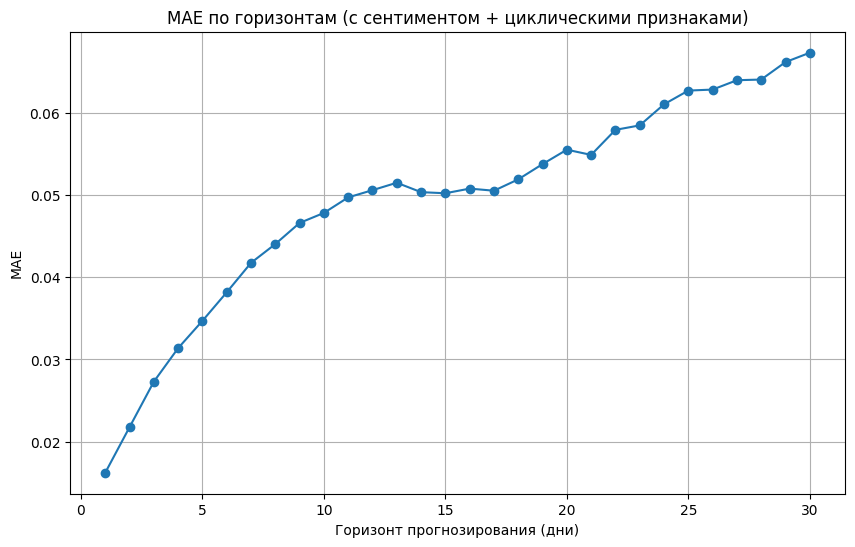

In [94]:
results_df = pd.DataFrame({
    "horizon": list(mae_by_horizon.keys()),
    "mae": list(mae_by_horizon.values())
}).sort_values("horizon")

print("\nMAE summary:")
print(results_df.head(10))

plt.figure(figsize=(10, 6))
plt.plot(results_df["horizon"], results_df["mae"], marker="o", linestyle="-")
plt.title("MAE по горизонтам (с сентиментом + циклическими признаками)")
plt.xlabel("Горизонт прогнозирования (дни)")
plt.ylabel("MAE")
plt.grid(True)
plt.show()

In [95]:
print(df['ticker'].unique())

['AFLT' 'ALRS' 'CHMF' 'GAZP' 'GMKN' 'LKOH' 'MAGN' 'MGNT' 'MOEX' 'MTSS'
 'NVTK' 'PHOR' 'PLZL' 'ROSN' 'RUAL' 'SBER' 'SIBN' 'T' 'VTBR']


Training Random Forest for Horizon 01...
Horizon 01: R2 Score = 0.9986, MAE = 0.0129
Training Random Forest for Horizon 02...
Horizon 02: R2 Score = 0.9971, MAE = 0.0203
Training Random Forest for Horizon 03...
Horizon 03: R2 Score = 0.9955, MAE = 0.0254
Training Random Forest for Horizon 04...
Horizon 04: R2 Score = 0.9939, MAE = 0.0301
Training Random Forest for Horizon 05...
Horizon 05: R2 Score = 0.9921, MAE = 0.0344
Training Random Forest for Horizon 06...
Horizon 06: R2 Score = 0.9899, MAE = 0.0390
Training Random Forest for Horizon 07...
Horizon 07: R2 Score = 0.9878, MAE = 0.0426
Training Random Forest for Horizon 08...
Horizon 08: R2 Score = 0.9864, MAE = 0.0455
Training Random Forest for Horizon 09...
Horizon 09: R2 Score = 0.9843, MAE = 0.0493
Training Random Forest for Horizon 10...
Horizon 10: R2 Score = 0.9826, MAE = 0.0517
Training Random Forest for Horizon 11...
Horizon 11: R2 Score = 0.9818, MAE = 0.0531
Training Random Forest for Horizon 12...
Horizon 12: R2 Score = 0

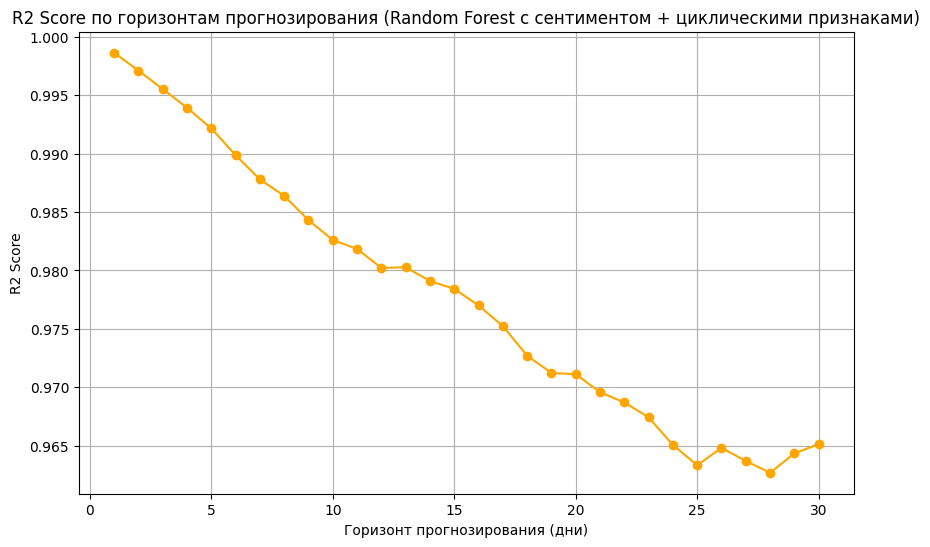

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

r2_results_rf = {}
mae_results_rf = {}
models_rf = {}
predictions_rf = {}


RF_PARAMS = dict(
    n_estimators=100,
    max_depth=10,
    random_state=41,
    n_jobs=-1
)


for h in range(1, days_horis + 1):
    target_col = f"target_{h}"
    print(f"Training Random Forest for Horizon {h:02d}...")

    model_rf = RandomForestRegressor(**RF_PARAMS)
    X_train_rf = X_train.copy()
    X_test_rf = X_test.copy()

    rf_cat_features = [col for col in cat_features if col in X_train_rf.columns and X_train_rf[col].dtype == 'object']

    if rf_cat_features:
        X_train_rf = pd.get_dummies(X_train_rf, columns=rf_cat_features, drop_first=True)
        X_test_rf = pd.get_dummies(X_test_rf, columns=rf_cat_features, drop_first=True)

        train_cols = set(X_train_rf.columns)
        test_cols = set(X_test_rf.columns)

        missing_in_test = list(train_cols - test_cols)
        for c in missing_in_test:
            X_test_rf[c] = 0

        missing_in_train = list(test_cols - train_cols)
        for c in missing_in_train:
            X_train_rf[c] = 0

        X_test_rf = X_test_rf[X_train_rf.columns]

    model_rf.fit(X_train_rf, y_train[target_col])
    models_rf[h] = model_rf

    y_pred_rf = model_rf.predict(X_test_rf)
    predictions_rf[h] = y_pred_rf

    r2 = r2_score(y_test[target_col], y_pred_rf)
    mae = mean_absolute_error(y_test[target_col], y_pred_rf)

    r2_results_rf[h] = r2
    mae_results_rf[h] = mae

    print(f"Horizon {h:02d}: R2 Score = {r2:.4f}, MAE = {mae:.4f}")

r2_results_df_rf = pd.DataFrame({
    "horizon": list(r2_results_rf.keys()),
    "r2_score": list(r2_results_rf.values())
}).sort_values("horizon")

print(r2_results_df_rf.head(10))

plt.figure(figsize=(10, 6))
plt.plot(r2_results_df_rf["horizon"], r2_results_df_rf["r2_score"], marker="o", linestyle="-", color='orange')
plt.title("R2 Score по горизонтам прогнозирования (Random Forest с сентиментом + циклическими признаками)")
plt.xlabel("Горизонт прогнозирования (дни)")
plt.ylabel("R2 Score")
plt.grid(True)
plt.show()

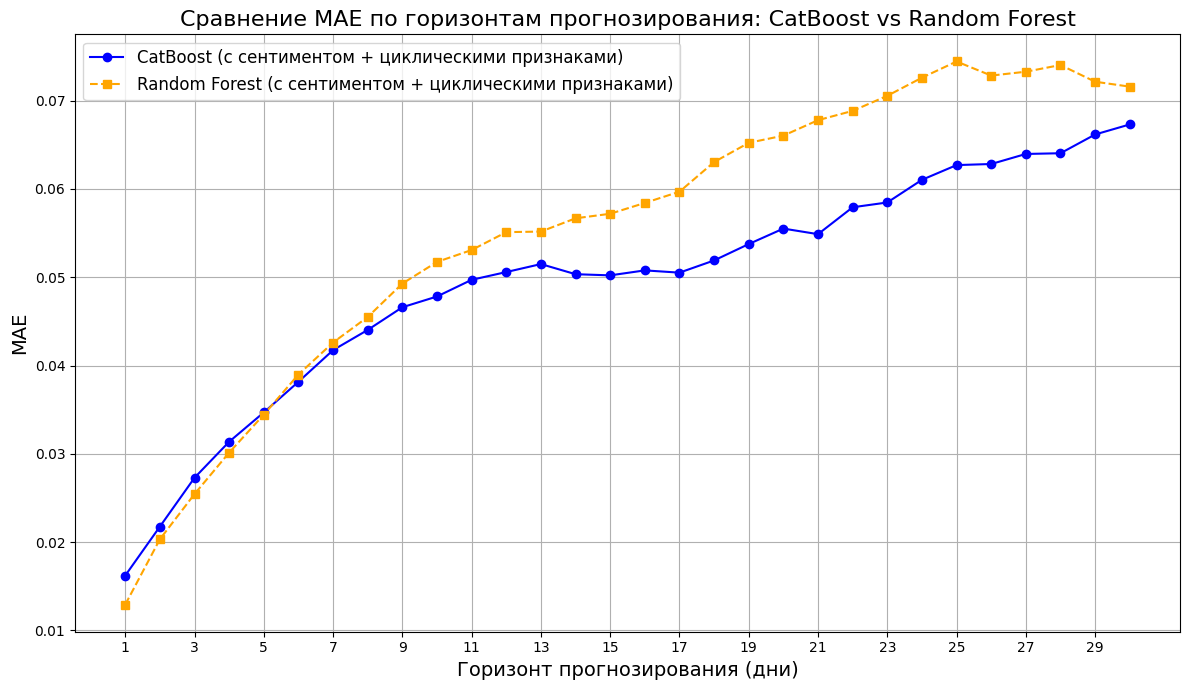


--- Сводка MAE: CatBoost vs Random Forest ---
   Horizon  MAE CatBoost  MAE Random Forest
0        1      0.016214           0.012927
1        2      0.021758           0.020328
2        3      0.027293           0.025446
3        4      0.031372           0.030142
4        5      0.034692           0.034445
5        6      0.038166           0.038986
6        7      0.041749           0.042611
7        8      0.044034           0.045501
8        9      0.046605           0.049287
9       10      0.047822           0.051739
    Horizon  MAE CatBoost  MAE Random Forest
20       21      0.054882           0.067795
21       22      0.057929           0.068848
22       23      0.058472           0.070554
23       24      0.061038           0.072607
24       25      0.062707           0.074442
25       26      0.062829           0.072845
26       27      0.063968           0.073284
27       28      0.064049           0.074042
28       29      0.066174           0.072150
29       30      0.

In [97]:
catboost_mae_df = pd.DataFrame({
    "horizon": list(mae_by_horizon.keys()),
    "mae": list(mae_by_horizon.values())
}).sort_values("horizon")

rf_mae_df = pd.DataFrame({
    "horizon": list(mae_results_rf.keys()),
    "mae": list(mae_results_rf.values())
}).sort_values("horizon")

plt.figure(figsize=(12, 7))
plt.plot(catboost_mae_df["horizon"], catboost_mae_df["mae"], marker='o', linestyle='-', color='blue', label='CatBoost (с сентиментом + циклическими признаками)')
plt.plot(rf_mae_df["horizon"], rf_mae_df["mae"], marker='s', linestyle='--', color='orange', label='Random Forest (с сентиментом + циклическими признаками)')

plt.title("Сравнение MAE по горизонтам прогнозирования: CatBoost vs Random Forest", fontsize=16)
plt.xlabel("Горизонт прогнозирования (дни)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(1, days_horis + 1, 2))
plt.tight_layout()
plt.show()

print("\n--- Сводка MAE: CatBoost vs Random Forest ---")
comparison_df = pd.DataFrame({
    "Horizon": catboost_mae_df["horizon"],
    "MAE CatBoost": catboost_mae_df["mae"],
    "MAE Random Forest": rf_mae_df["mae"]
})
print(comparison_df.head(10))
print(comparison_df.tail(10))

In [98]:
from sklearn.linear_model import Ridge

In [128]:
mae_results_ridge = {}
models_ridge = {}
predictions_ridge = {}

for i in range(5, 10, 5):

  RIDGE_PARAMS = {
      'alpha': 40,  #
      'random_state': 42
  }

  for h in range(1, days_horis + 1):
      target_col = f"target_{h}"
      print(f"Training Ridge for Horizon {h:02d}...")

      model_ridge = Ridge(**RIDGE_PARAMS)

      model_ridge.fit(X_train_rf, y_train[target_col])
      models_ridge[h] = model_ridge

      y_pred_ridge = model_ridge.predict(X_test_rf)
      predictions_ridge[h] = y_pred_ridge

      mae = mean_absolute_error(y_test[target_col], y_pred_ridge)
      mae_results_ridge[h] = mae

      print(f"Horizon {h:02d}: MAE = {mae:.4f}")

Training Ridge for Horizon 01...
Horizon 01: MAE = 0.0143
Training Ridge for Horizon 02...
Horizon 02: MAE = 0.0206
Training Ridge for Horizon 03...
Horizon 03: MAE = 0.0255
Training Ridge for Horizon 04...
Horizon 04: MAE = 0.0300
Training Ridge for Horizon 05...
Horizon 05: MAE = 0.0333
Training Ridge for Horizon 06...
Horizon 06: MAE = 0.0370
Training Ridge for Horizon 07...
Horizon 07: MAE = 0.0403
Training Ridge for Horizon 08...
Horizon 08: MAE = 0.0426
Training Ridge for Horizon 09...
Horizon 09: MAE = 0.0451
Training Ridge for Horizon 10...
Horizon 10: MAE = 0.0472
Training Ridge for Horizon 11...
Horizon 11: MAE = 0.0487
Training Ridge for Horizon 12...
Horizon 12: MAE = 0.0500
Training Ridge for Horizon 13...
Horizon 13: MAE = 0.0504
Training Ridge for Horizon 14...
Horizon 14: MAE = 0.0509
Training Ridge for Horizon 15...
Horizon 15: MAE = 0.0506
Training Ridge for Horizon 16...
Horizon 16: MAE = 0.0505
Training Ridge for Horizon 17...
Horizon 17: MAE = 0.0508
Training Ridge

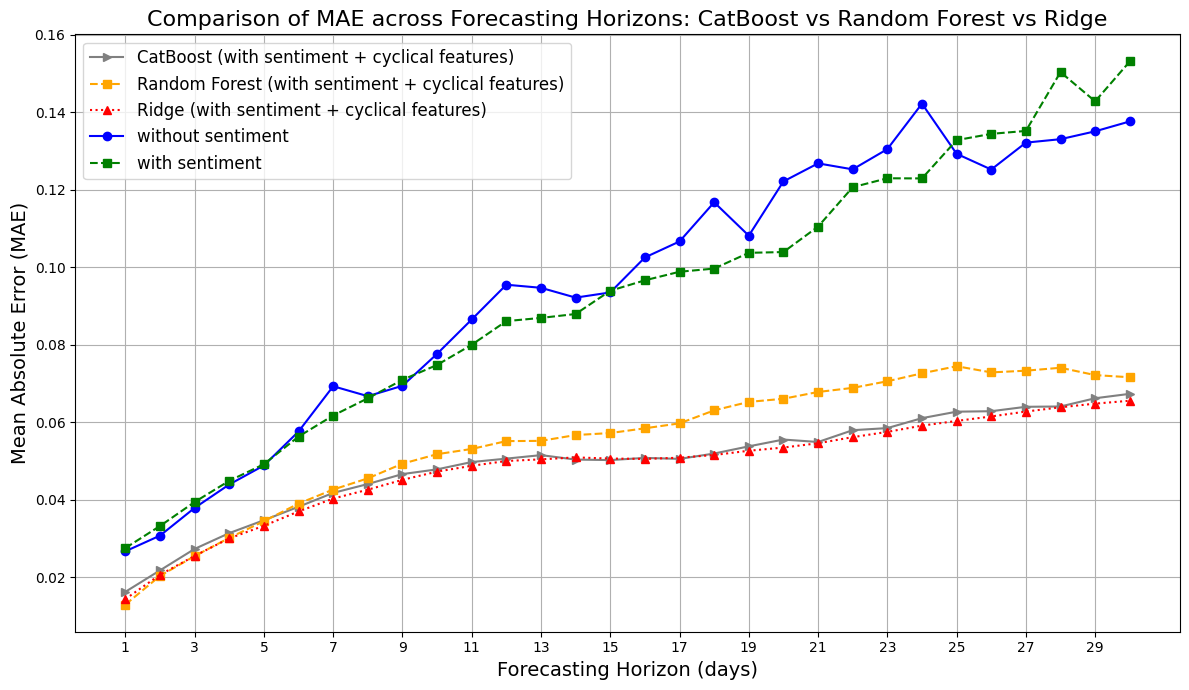

   Horizon  MAE CatBoost  MAE Random Forest  MAE Ridge
0        1      0.016214           0.012927   0.014348
1        2      0.021758           0.020328   0.020613
2        3      0.027293           0.025446   0.025485
3        4      0.031372           0.030142   0.030015
4        5      0.034692           0.034445   0.033260
5        6      0.038166           0.038986   0.036955
6        7      0.041749           0.042611   0.040288
7        8      0.044034           0.045501   0.042576
8        9      0.046605           0.049287   0.045120
9       10      0.047822           0.051739   0.047243
    Horizon  MAE CatBoost  MAE Random Forest  MAE Ridge
20       21      0.054882           0.067795   0.054563
21       22      0.057929           0.068848   0.056132
22       23      0.058472           0.070554   0.057492
23       24      0.061038           0.072607   0.059105
24       25      0.062707           0.074442   0.060318
25       26      0.062829           0.072845   0.061475
26 

In [129]:
catboost_mae_df = pd.DataFrame({
    "horizon": list(mae_by_horizon.keys()),
    "mae": list(mae_by_horizon.values())
}).sort_values("horizon")

rf_mae_df = pd.DataFrame({
    "horizon": list(mae_results_rf.keys()),
    "mae": list(mae_results_rf.values())
}).sort_values("horizon")

ridge_mae_df = pd.DataFrame({
    "horizon": list(mae_results_ridge.keys()),
    "mae": list(mae_results_ridge.values())
}).sort_values("horizon")


plt.figure(figsize=(12, 7))
plt.plot(catboost_mae_df["horizon"], catboost_mae_df["mae"], marker='>', linestyle='solid', color='gray', label='CatBoost (with sentiment + cyclical features)')
plt.plot(rf_mae_df["horizon"], rf_mae_df["mae"], marker='s', linestyle='--', color='orange', label='Random Forest (with sentiment + cyclical features)')
plt.plot(ridge_mae_df["horizon"], ridge_mae_df["mae"], marker='^', linestyle=':', color='red', label='Ridge (with sentiment + cyclical features)')
plt.plot(horizons, mae_values, marker='o', linestyle='-', color='blue', label='without sentiment')
plt.plot(horizons, mae_values_sentiment, marker='s', linestyle='--', color='green', label='with sentiment')

plt.title("Comparison of MAE across Forecasting Horizons: CatBoost vs Random Forest vs Ridge", fontsize=16)
plt.xlabel("Forecasting Horizon (days)", fontsize=14)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(1, days_horis + 1, 2))
plt.tight_layout()
plt.show()

comparison_df_all = pd.DataFrame({
    "Horizon": catboost_mae_df["horizon"],
    "MAE CatBoost": catboost_mae_df["mae"],
    "MAE Random Forest": rf_mae_df["mae"],
    "MAE Ridge": ridge_mae_df["mae"]
})
print(comparison_df_all.head(10))
print(comparison_df_all.tail(10))

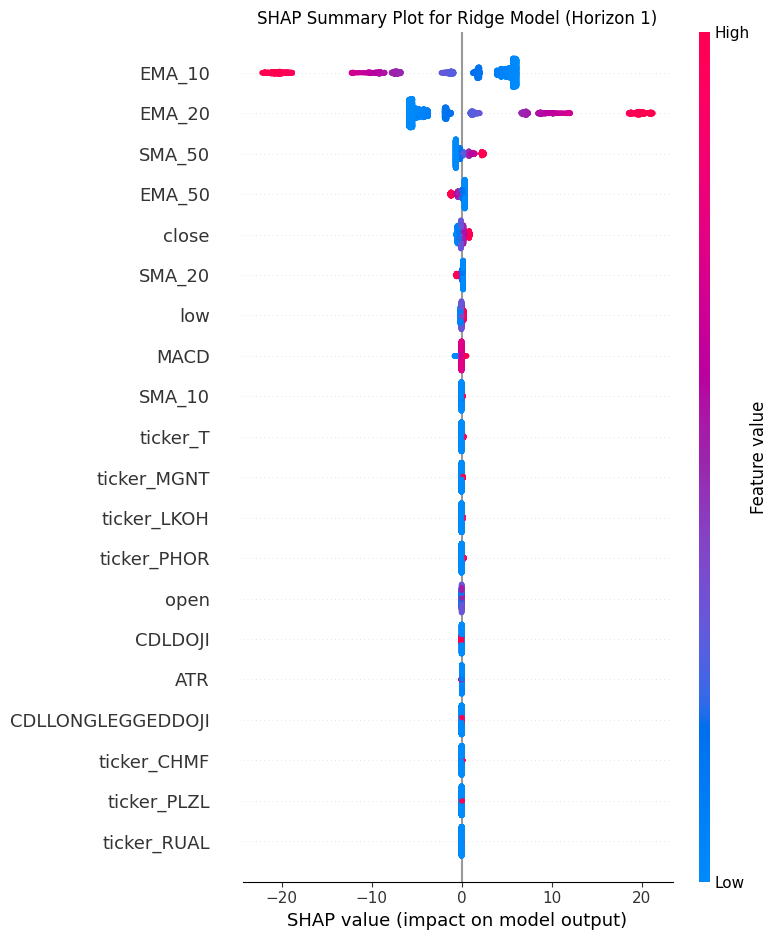

In [103]:
!pip install shap
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

model_to_explain_ridge = models_ridge[15]


def ensure_numeric_df(df_input):
    df_output = df_input.copy()
    for col in df_output.columns:
        if df_output[col].dtype == 'bool':
            df_output[col] = df_output[col].astype(int)
        elif not pd.api.types.is_numeric_dtype(df_output[col]):
            df_output[col] = pd.to_numeric(df_output[col], errors='coerce')
    return df_output.fillna(0)
X_train_rf_numeric = ensure_numeric_df(X_train_rf)
X_test_rf_numeric = ensure_numeric_df(X_test_rf)

explainer_ridge = shap.LinearExplainer(model_to_explain_ridge, X_train_rf_numeric)

shap_values_ridge = explainer_ridge.shap_values(X_test_rf_numeric)

shap_values_ridge = np.asarray(shap_values_ridge, dtype=np.float64)
shap_values_ridge[~np.isfinite(shap_values_ridge)] = 0

shap.summary_plot(shap_values_ridge, X_test_rf_numeric, show=False)
plt.title("SHAP Summary Plot for Ridge Model (Horizon 1)")
plt.tight_layout()
plt.show()

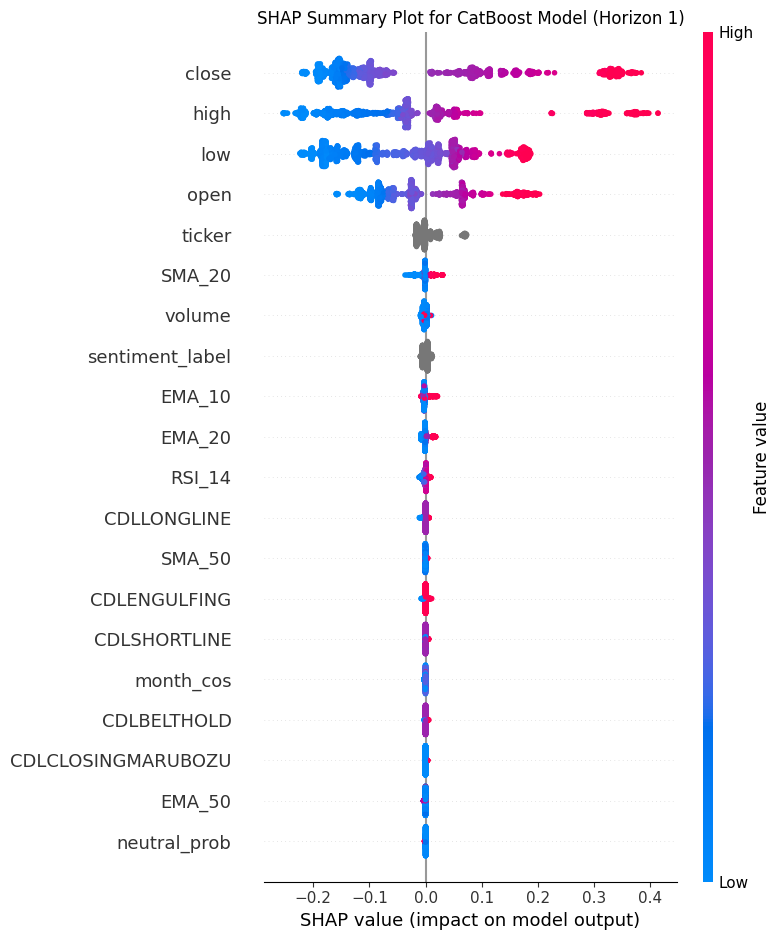

In [109]:
import shap
import matplotlib.pyplot as plt
import numpy as np

catboost_model_h1 = models[1]

explainer_catboost = shap.TreeExplainer(catboost_model_h1, feature_perturbation="tree_path_dependent")

shap_values_catboost = explainer_catboost.shap_values(X_test)

shap_values_catboost = np.asarray(shap_values_catboost, dtype=np.float64)
shap_values_catboost[~np.isfinite(shap_values_catboost)] = 0

shap.summary_plot(shap_values_catboost, X_test, show=False)
plt.title("SHAP Summary Plot for CatBoost Model (Horizon 1)")
plt.tight_layout()
plt.show()

In [130]:
pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=7f67dcebe1a5e19754a8faf9e65fa50563185d7d858b49e1f3c9624115c3cd0c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [136]:
import lime
import lime.lime_tabular

In [139]:

model_to_explain = models_ridge[1]

explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_rf.values,
    feature_names=X_train_rf.columns.tolist(),
    categorical_features=[i for i, col in enumerate(X_train_rf.columns) if col.startswith(('ticker_', 'sentiment_label_'))],
    mode='regression'
)

In [141]:
i = 0
exp = explainer_lime.explain_instance(
    data_row=X_test_rf.iloc[i].values,
    predict_fn=model_to_explain.predict,
    num_features=30
)

print(f"Истинное значение: {y_test['target_1'].iloc[i]:.4f}")
print(f"Предсказание модели: {model_to_explain.predict([X_test_rf.iloc[i]])[0]:.4f}")
exp.show_in_notebook(show_table=True)

Истинное значение: 0.8695
Предсказание модели: 0.8529


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


так как у нас LIME не работает, посмотрим еще и на просто FI.

            feature  importance
2              high   29.927773
1             close   27.149293
3               low   20.466400
0              open   17.151202
79           EMA_10    1.008126
12        month_sin    0.759767
5            ticker    0.672911
44           SMA_20    0.641404
66           EMA_20    0.332630
19           RSI_14    0.258180
4            volume    0.190309
45           SMA_50    0.161171
7   sentiment_label    0.150750
13        month_cos    0.128089
63           SMA_10    0.099376
29      MACD_signal    0.088668
64             MACD    0.087367
24  CDLSHOOTINGSTAR    0.064522
34           EMA_50    0.063387
36      CDLDOJISTAR    0.057883


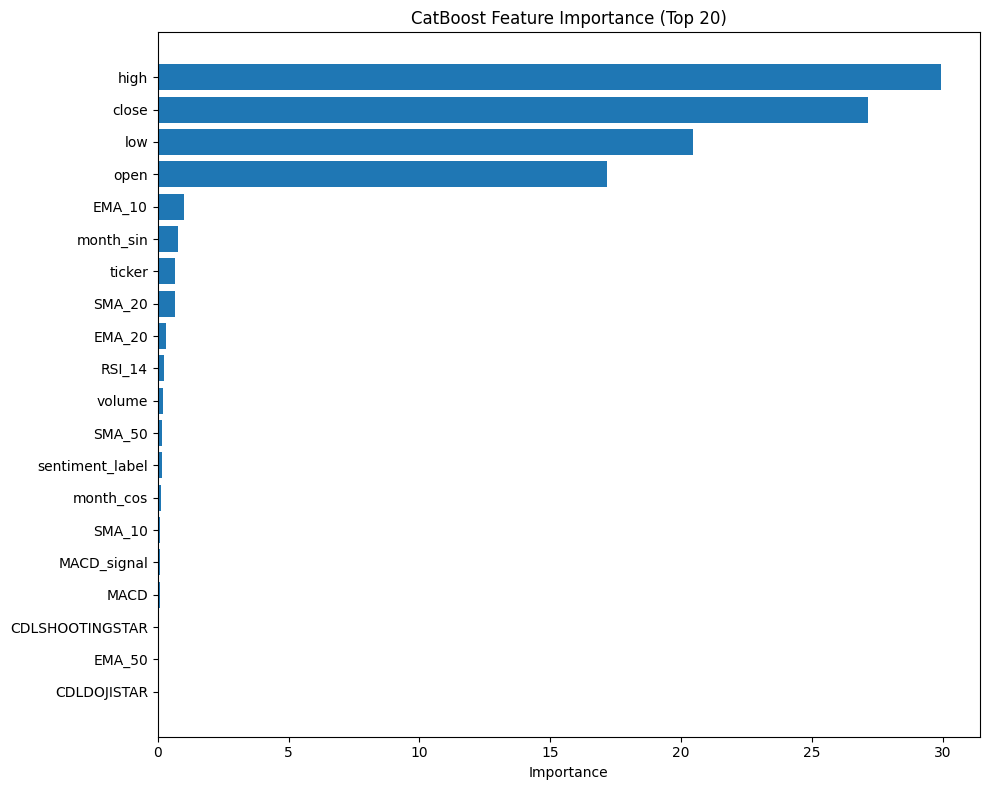

In [143]:
importances = model.get_feature_importance()
feature_names = X_train.columns

fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)
print(fi_df.head(20))

plt.figure(figsize=(10, 8))
plt.barh(fi_df['feature'].head(20), fi_df['importance'].head(20))
plt.gca().invert_yaxis()
plt.title('CatBoost Feature Importance (Top 20)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Тут у нас появляется достаточное понимание, что ridge помаксимуму использовала новые фичи, которые были созданы нами. Если же говорить про кетбуст, то он использовал основную информацию, которая уже была в датасете. Есть кончено же в топах признаков обоих моделей одни и теже признаки. Но их не то что много. А значит они по разному понимают данные

Посмотрим на такой признка как EMA_10. ДАнный признак обладает хорошой предсказуемостью относительно таргета. Допустим с помощью лайма мы поняли что в ридже он дает для прогноза на 1 день + 4.88 к базовому прогнозу. В Случае кетбуста все не так сильно. Данная фича не приносит значимый вклад

получим sharp - enbending

In [159]:
import shap


h = 1
model_ridge = models_ridge[h]

assert list(X_train_rf.columns) == list(X_test_rf.columns)

explainer = shap.LinearExplainer(
    model_ridge,
    X_train_rf.values,
    feature_perturbation="interventional"
)

shap_values_ridge = explainer(X_test_rf.values)

shap_df_ridge = pd.DataFrame(
    shap_values_ridge.values,
    columns=X_test_rf.columns,
    index=X_test_rf.index
)

print(shap_df_ridge.shape)
shap_df_ridge.head(3)

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


(1876, 105)


open     close      high       low    volume sentiment_score  \
22565 -0.069653 -0.130315 -0.103287 -0.095852  0.000131       -0.000072   
22566 -0.085243  -0.16271 -0.127177 -0.119089  0.000132       -0.000072   
22567  -0.01946  -0.02694 -0.025344 -0.021003  0.000132       -0.000072   

      positive_prob neutral_prob negative_prob confidence  ... ticker_PHOR  \
22565      0.000284     0.000241      0.000173  -0.000536  ...   -0.000056   
22566      0.000284     0.000241      0.000173  -0.000536  ...   -0.000056   
22567      0.000284     0.000241      0.000173  -0.000536  ...   -0.000056   

      ticker_PLZL ticker_ROSN ticker_RUAL ticker_SBER ticker_SIBN  ticker_T  \
22565    0.000402   -0.000112   -0.000171    0.000071    -0.00006 -0.001634   
22566    0.000402   -0.000112   -0.000171    0.000071    -0.00006 -0.001634   
22567    0.000402   -0.000112   -0.000171    0.000071    -0.00006 -0.001634   

      ticker_VTBR sentiment_label_0.0 sentiment_label_1.0  
22565   -0.000241                -0.0            0.000199  
22566   -0.000241                -0.0            0.000199  
22567   -0.000241                -0.0            0.000199  

[3 rows x 105 columns]

#  Проверка гипотезы о влиянии новостей

In [147]:
features_no_sentiment = [f for f in features if f not in sentiment_cols]
X_train_no_s = train_df[features_no_sentiment].copy()
X_test_no_s = test_df[features_no_sentiment].copy()
y_train_no_s = train_df[targets]
y_test_no_s = test_df[targets]

cat_features_clean = [c for c in cat_features if c in features_no_sentiment]

X_train_no_s_enc = pd.get_dummies(X_train_no_s, columns=cat_features_clean, drop_first=True)
X_test_no_s_enc = pd.get_dummies(X_test_no_s, columns=cat_features_clean, drop_first=True)

for col in X_train_no_s_enc.columns:
    if col not in X_test_no_s_enc.columns:
        X_test_no_s_enc[col] = 0
for col in X_test_no_s_enc.columns:
    if col not in X_train_no_s_enc.columns:
        X_train_no_s_enc[col] = 0

X_test_no_s_enc = X_test_no_s_enc[X_train_no_s_enc.columns]

mae_ridge_no_sentiment = {}
models_ridge_no_s = {}
preds_ridge_no_s = {}

RIDGE_PARAMS = {
    'alpha': 40,
    'random_state': 69
}

for h in range(1, days_horis + 1):
    target_col = f"target_{h}"
    print(f"Training Ridge (без сентимента) для горизонта {h}...")

    model = Ridge(**RIDGE_PARAMS)
    model.fit(X_train_no_s_enc, y_train_no_s[target_col])

    y_pred = model.predict(X_test_no_s_enc)
    mae = mean_absolute_error(y_test_no_s[target_col], y_pred)

    models_ridge_no_s[h] = model
    preds_ridge_no_s[h] = y_pred
    mae_ridge_no_sentiment[h] = mae


ridge_no_s_df = pd.DataFrame({
    "horizon": list(mae_ridge_no_sentiment.keys()),
    "mae_no_sentiment": list(mae_ridge_no_sentiment.values())
}).sort_values("horizon")

print("MAE Ridge (без сентимент-фич):")
print(ridge_no_s_df)

Training Ridge (без сентимента) для горизонта 1...
Training Ridge (без сентимента) для горизонта 2...
Training Ridge (без сентимента) для горизонта 3...
Training Ridge (без сентимента) для горизонта 4...
Training Ridge (без сентимента) для горизонта 5...
Training Ridge (без сентимента) для горизонта 6...
Training Ridge (без сентимента) для горизонта 7...
Training Ridge (без сентимента) для горизонта 8...
Training Ridge (без сентимента) для горизонта 9...
Training Ridge (без сентимента) для горизонта 10...
Training Ridge (без сентимента) для горизонта 11...
Training Ridge (без сентимента) для горизонта 12...
Training Ridge (без сентимента) для горизонта 13...
Training Ridge (без сентимента) для горизонта 14...
Training Ridge (без сентимента) для горизонта 15...
Training Ridge (без сентимента) для горизонта 16...
Training Ridge (без сентимента) для горизонта 17...
Training Ridge (без сентимента) для горизонта 18...
Training Ridge (без сентимента) для горизонта 19...
Training Ridge (без с

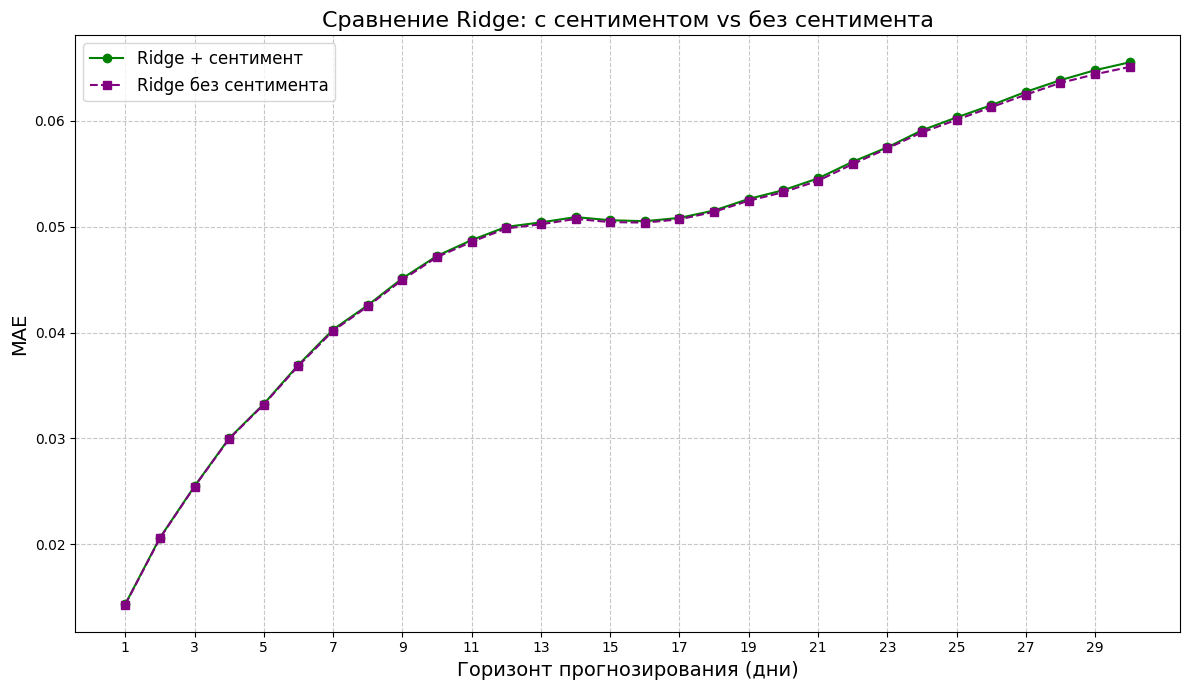


Сентимент улучшил MAE на 0 из 30 горизонтов.

Среднее MAE:
  С сентиментом:    0.0484
  Без сентимента:   0.0482


In [148]:
ridge_with_sent = ridge_mae_df.sort_values("horizon").set_index("horizon")["mae"]
ridge_without_sent = ridge_no_s_df.sort_values("horizon").set_index("horizon")["mae_no_sentiment"]

plt.figure(figsize=(12, 7))
plt.plot(ridge_with_sent.index, ridge_with_sent.values,
         marker='o', linestyle='-', color='green', label='Ridge + сентимент')
plt.plot(ridge_without_sent.index, ridge_without_sent.values,
         marker='s', linestyle='--', color='purple', label='Ridge без сентимента')

plt.title("Сравнение Ridge: с сентиментом vs без сентимента", fontsize=16)
plt.xlabel("Горизонт прогнозирования (дни)", fontsize=14)
plt.ylabel("MAE", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(range(1, days_horis + 1, 2))
plt.tight_layout()
plt.show()


diff = ridge_with_sent - ridge_without_sent
improved = (diff < 0).sum()
print(f"\nСентимент улучшил MAE на {improved} из {len(diff)} горизонтов.")
print("\nСреднее MAE:")
print(f"С сентиментом:    {ridge_with_sent.mean():.4f}")
print(f"Без сентимента:   {ridge_without_sent.mean():.4f}")